# Navigating Safety: Optimizing Traffic Sign Detection Models.

## Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2
import random
from matplotlib.image import imread
from ultralytics import YOLO
import seaborn as sns
import torch
import shutil
import glob

## Data Prepairation 

Dataset : German Traffic Sign Recognition Benchmark



### The number of classes and their labels

The number of classes in GTSRB dataset is : 43


C:\Users\96278\AppData\Local\Temp\ipykernel_17796\2418829927.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


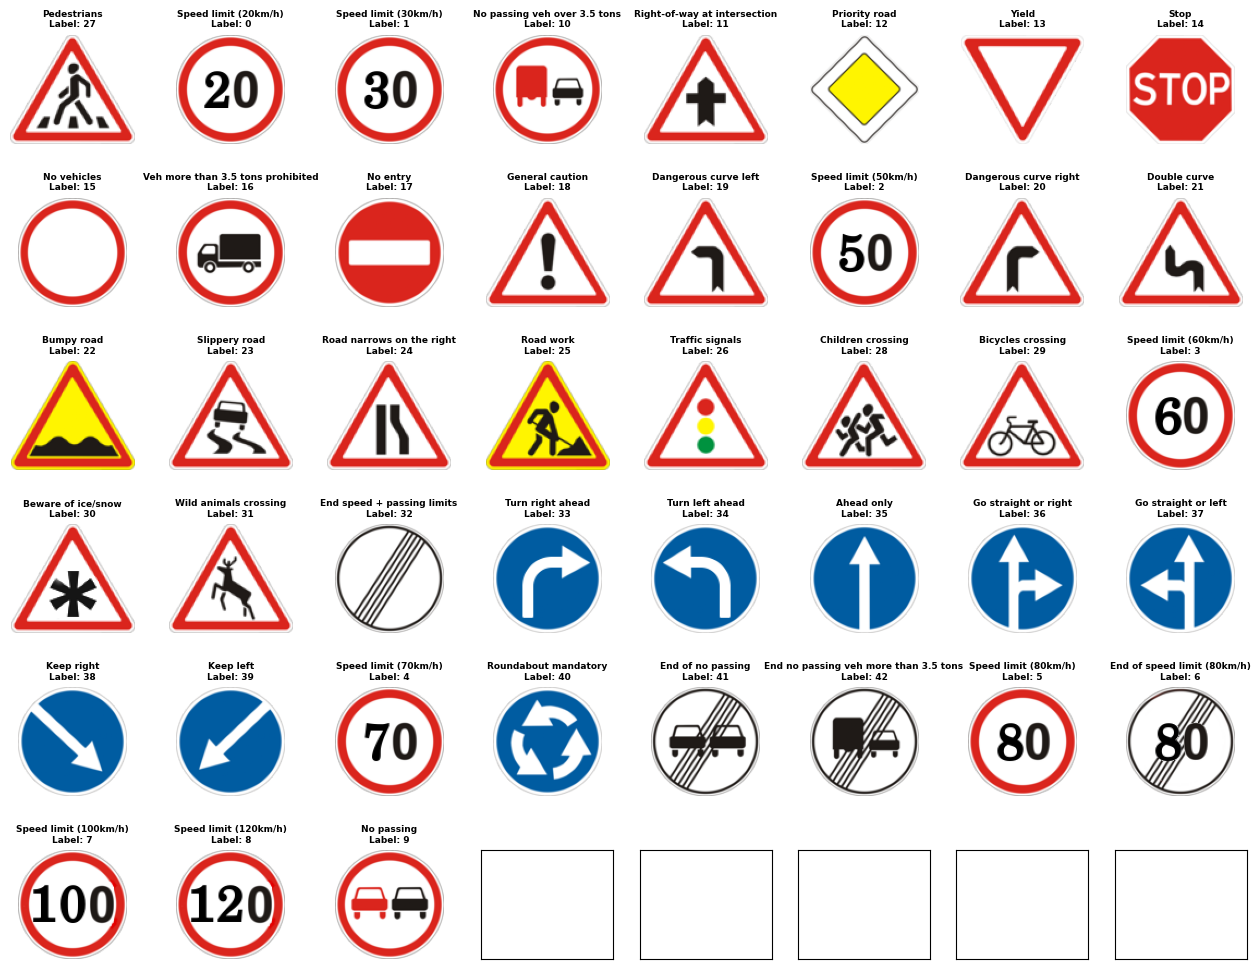

In [14]:
number_of_classes_GTSRB = len(os.listdir("GTSRB_data/Train"))
print (f"The number of classes in GTSRB dataset is : {number_of_classes_GTSRB}")

# Load the Meta.csv file
meta_data_GTSRB = pd.read_csv('GTSRB_data/Meta.csv')  


# dictionary of class IDs and their labels
classes_GTSRB = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh more than 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh more than 3.5 tons' }


def plot_images_with_info(data, rows, cols,set,dict):
    total_images = rows * cols
   
    total_images = min(total_images, len(data))
 
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12), 
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
    for i in range(total_images):
        image_path = data.iloc[i]['Path']
        class_id = data.iloc[i]['ClassId']

        class_label = dict.get(class_id, 'Unknown')

        img = mpimg.imread(set+"/"+image_path)
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.set_title(f'{class_label}\nLabel: {data.iloc[i]["ClassId"]}',fontsize=6.5,fontweight="bold")
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_images_with_info(meta_data_GTSRB, rows=6, cols=8,set="GTSRB_data",dict=classes_GTSRB)


### Convert the images format from PNG to JPG 

In [41]:
def convert_png_to_jpg(folder):
    
    for folder_name in os.listdir(folder):
        folder_path = os.path.join(folder, folder_name)

        if os.path.isdir(folder_path):
            
            for filename in os.listdir(folder_path):
                if filename.lower().endswith('.png'):
                    png_path = os.path.join(folder_path, filename)
                    jpg_path = os.path.join(folder_path, os.path.splitext(filename)[0] + '.jpg')
                    
                    
                    Image.open(png_path).convert('RGB').save(jpg_path, 'JPEG')
                    
                    os.remove(png_path)

convert_png_to_jpg(os.path.join("GTSRB_data/Train"))



In [42]:
def convert_png_to_jpg(image_folder):
    for filename in os.listdir(image_folder):
        if filename.lower().endswith('.png'):
            png_path = os.path.join(image_folder, filename)
            jpg_path = os.path.join(image_folder, os.path.splitext(filename)[0] + '.jpg')
            Image.open(png_path).convert('RGB').save(jpg_path, 'JPEG')
            os.remove(png_path)  

convert_png_to_jpg("GTSRB_data/Test")


### Resizing the images and splitting them to training , validation and testing datasets

In [43]:
def load_images_and_labels(csv_file, image_folder, target_size=(100, 100)):
    data = pd.read_csv(csv_file)
    features = []
    labels = []
    
    for index, row in data.iterrows():
        image_path = os.path.join(image_folder, row['Path'])
        image = Image.open(image_path).convert('RGB')  # Ensuring images are in RGB format
        image = image.resize(target_size)
        image = np.array(image)
        features.append(image)
        labels.append(row['ClassId'])
    
    return np.array(features), np.array(labels)



# Load train data
train_features_GTSRB, train_labels_GTSRB = load_images_and_labels('GTSRB_data/Train.csv', 'GTSRB_data')

# Split the data into training and validation sets (80% training, 30% validation)
train_features_GTSRB, val_features_GTSRB, train_labels_GTSRB, val_labels_GTSRB = train_test_split(
    train_features_GTSRB, train_labels_GTSRB, test_size=0.3, random_state=42)

# Load and resize test data
test_features_GTSRB, test_labels_GTSRB = load_images_and_labels('GTSRB_data/Test.csv', 'GTSRB_data')

# Save data to pickle files to use them later 
train_data_GTSRB = {'features': train_features_GTSRB, 'labels': train_labels_GTSRB}
val_data_GTSRB = {'features': val_features_GTSRB, 'labels': val_labels_GTSRB}
test_data_GTSRB = {'features': test_features_GTSRB, 'labels': test_labels_GTSRB}

with open('train_GTSRB.pickle', 'wb') as f:
    pickle.dump(train_data_GTSRB, f)

with open('val_GTSRB.pickle', 'wb') as f:
    pickle.dump(val_data_GTSRB, f)

with open('test_GTSRB.pickle', 'wb') as f:
    pickle.dump(test_data_GTSRB, f)



### Loading the data

In [2]:
def load_rgb_data(file):
    # Opening 'pickle' file and getting images
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')  
            # It is needed to divide float by float when applying Normalization
        x = d['features'].astype(np.float32)   # 4D numpy.ndarray type
        y = d['labels']                        # 1D numpy.ndarray type
        
    return x, y


# Loading rgb data from training dataset
x_train, y_train = load_rgb_data('train_GTSRB.pickle')

# Loading rgb data from validation dataset
x_validation, y_validation = load_rgb_data('val_GTSRB.pickle')

# Loading rgb data from test dataset
x_test, y_test,  = load_rgb_data('test_GTSRB.pickle')

In [45]:
print(f"The shape of x_train is: {x_train.shape}")
print(f"The shape of y_train is: {y_train.shape}")
print(f"The shape of x_validation is: {x_validation.shape}")
print(f"The shape of y_validation is: {y_validation.shape}")
print(f"The shape of x_test is: {x_test.shape}")
print(f"The shape of y_test is: {y_test.shape}")

The shape of x_train is: (27446, 100, 100, 3)
The shape of y_train is: (27446,)
The shape of x_validation is: (11763, 100, 100, 3)
The shape of y_validation is: (11763,)
The shape of x_test is: (12630, 100, 100, 3)
The shape of y_test is: (12630,)


### Display random images from the dataset

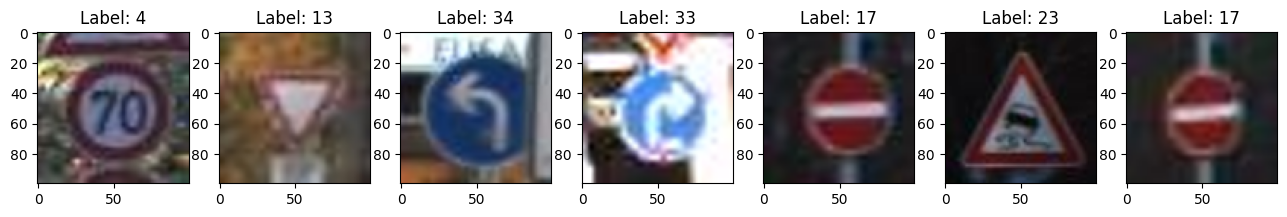

In [12]:
def display_random_images(images, labels, num_images=7):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(16, 2))
    for i, index in enumerate(indices):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[index].astype('uint8'))  
        plt.title(f"Label: {labels[index]}")
        plt.axis('on')
    plt.show()

display_random_images(x_train, y_train)


### Data Visualzation

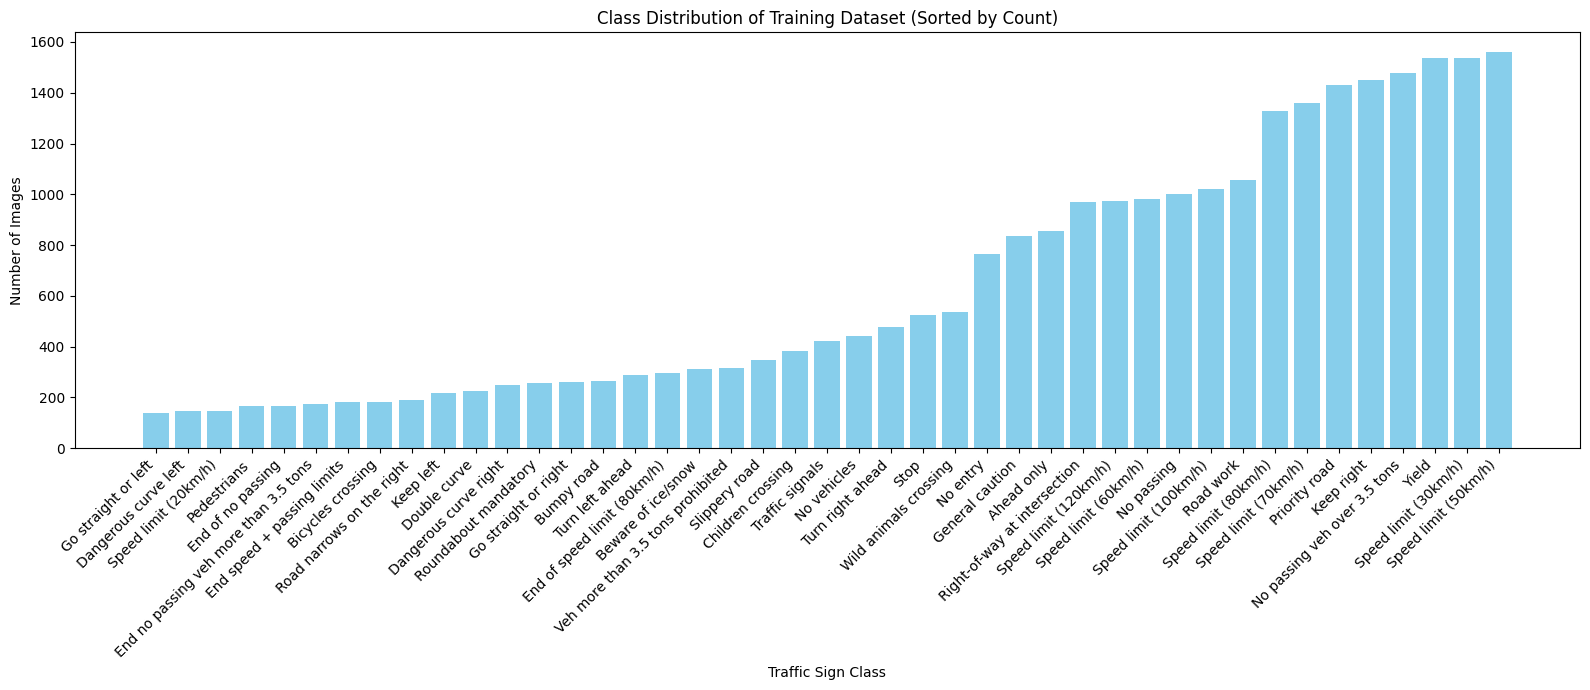

In [47]:

unique_labels, class_counts = np.unique(y_train, return_counts=True)

class_names = [classes_GTSRB[label] for label in unique_labels]

# Sort the data:
sorted_indices = np.argsort(class_counts)
sorted_class_names = np.array(class_names)[sorted_indices]
sorted_class_counts = class_counts[sorted_indices]

plt.figure(figsize=(16, 7))
plt.bar(sorted_class_names, sorted_class_counts, color='skyblue')
plt.xlabel("Traffic Sign Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Training Dataset (Sorted by Count)")
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()


#### Checking the Distribution of the Heights and Widths of the images 

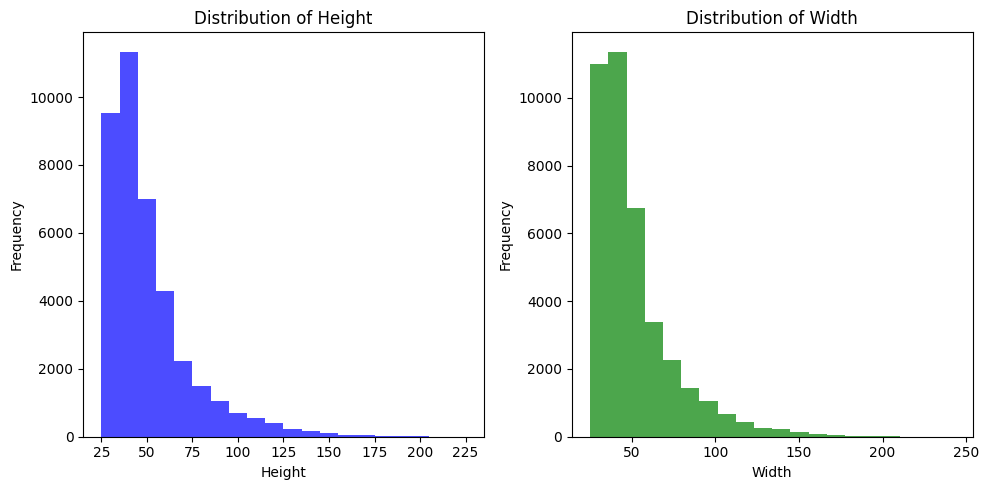

In [48]:
# checking the distrepution of the heights and width of the images

data = pd.read_csv("GTSRB_data/Train.csv")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(data['Height'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['Width'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of Width')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Data Equalization

Equalization function:

In [49]:

# Rotation:

def change_rotation(image):
    # angle range
    range = 25
    angle_rotation = np.random.uniform(range) - range / 2
    rows, columns, channels = image.shape
    transform_matrix = cv2.getRotationMatrix2D((columns / 2, rows / 2), angle_rotation, 1)
    # reshaping the original image using an affine matrix
    rotated_image = cv2.warpAffine(image, transform_matrix, (columns, rows))
    
    return rotated_image

def random_image(x_train, y_train, y_number):
    # defining an array for storing indexes 
    image_indexes = np.where(y_train == y_number)
    # getting a random index of the needed label
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    # returning a random image

    return x_train[image_indexes][random_index]

def Equalization(x_train, y_train):
    examples_per_label = np.bincount(y_train)
    number_of_labels = np.arange(len(examples_per_label))

    # iterating over all  labels
    for i in tqdm(number_of_labels):
        # finding how many more instances should be added for the current label
        required_examples = int(np.mean(examples_per_label) * 2.5) - \
                                    examples_per_label[i]

        # temporary arrays to store the new images
        x_temp = []
        y_temp = []

        # transforming the images 
        for j in range(required_examples):
            getting_random_image = random_image(x_train, y_train, i)
            x_temp.append(change_rotation(getting_random_image))
            y_temp.append(i)

        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)

    return x_train, y_train


x_train, y_train = Equalization(x_train.astype(np.uint8), y_train)


100%|██████████| 43/43 [02:12<00:00,  3.07s/it]


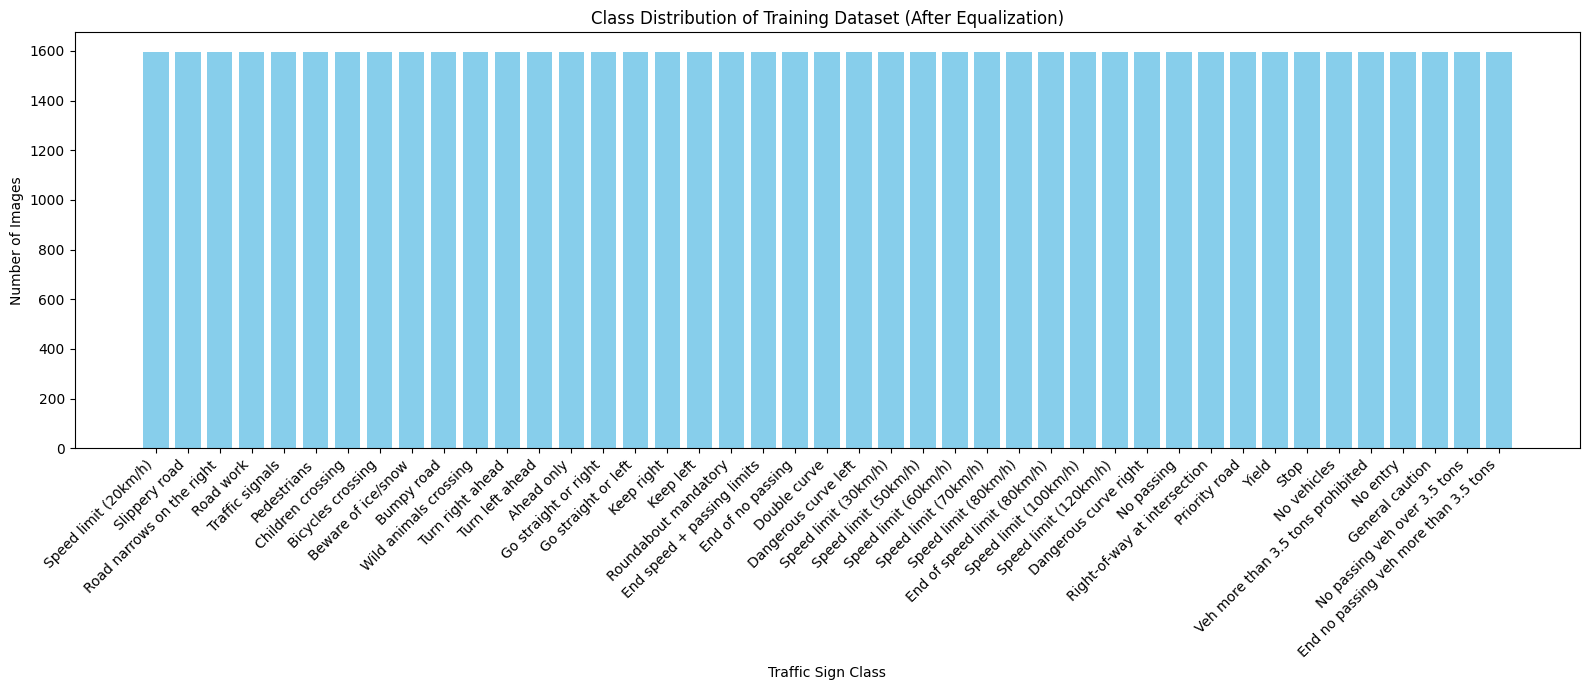

In [50]:
unique_labels, class_counts = np.unique(y_train, return_counts=True)


class_names = [classes_GTSRB[label] for label in unique_labels]

# Sorting the data in ascending order
sorted_indices = np.argsort(class_counts)
sorted_class_names = np.array(class_names)[sorted_indices]
sorted_class_counts = class_counts[sorted_indices]

plt.figure(figsize=(16, 7))
plt.bar(sorted_class_names, sorted_class_counts, color='skyblue')
plt.xlabel("Traffic Sign Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Training Dataset (After Equalization)")
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

### Data preprocessing

255.0 Normalization


In [ ]:
# Defining function for preprocessing loaded data
def preprocess_data(d,  norm_255=False ,colour='rgb'):

    # Applying /255.0 Normalization
    if norm_255:
        # Normalizing whole data by dividing /255.0
        d['x_train'] = d['x_train'].astype(np.float32) / 255.0
        d['x_validation'] /= 255.0
        d['x_test'] /= 255.0

    # Returning preprocessed data
    return d

In [ ]:
# Putting loaded and equalized data into the dictionary
d_loaded = {'x_train': x_train, 'y_train': y_train,
            'x_validation': x_validation, 'y_validation': y_validation,
            'x_test': x_test, 'y_test': y_test,
            }

# Applying preprocessing
data0 = preprocess_data(d_loaded)

# Saving loaded and preprocessed data into 'pickle' file
with open('data0.pickle', 'wb') as f:
    pickle.dump(data0, f)
# Releasing memory
del data0

# 'data0.pickle' is the data without normalization



In [53]:
# Applying preprocessing ( /255.0 Normalization )
# Loading 'data0.pickle' (The data without Normalization)

with open('data0.pickle', 'rb') as f:
    d_0_1 = pickle.load(f, encoding='latin1')  

data1 = preprocess_data(d_0_1, norm_255=True, colour='rgb')
# saving preprocessed data into 'pickle' file
with open('data1.pickle', 'wb') as f:
    pickle.dump(data1, f)
# Releasing memory
del d_0_1
del data1

### Loading the equalized and preprocessed data

In [2]:
with open('data1.pickle', 'rb') as file:
   dataset = pickle.load(file)

x_train, y_train = dataset["x_train"],dataset["y_train"]
x_validation,y_validation= dataset["x_validation"],dataset["y_validation"]
x_test,y_test= dataset["x_test"],dataset["y_test"]


### Saving training and validation data into YOLO format 

In [3]:
def YOLO_format(x_data, y_data, output_folder):
    # Iterate through each class
    for class_label in tqdm(np.unique(y_data)):
        class_folder = os.path.join(output_folder, str(class_label))
        os.makedirs(class_folder, exist_ok=True)

        # Get indices of images belonging to the current class
        class_indices = np.where(y_data == class_label)[0]

        # Iterate through images of the current class
        for idx in class_indices:
            image = x_data[idx]

            # Convert RGB to BGR
            image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            image_filename = f"{idx}.jpg"
            image_path = os.path.join(class_folder, image_filename)

            cv2.imwrite(image_path, image_bgr)


output_folder = "C:/Users/96278/OneDrive/Desktop/Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models/data1_YOLO/train"

YOLO_format(x_train, y_train, output_folder)


100%|██████████| 43/43 [01:32<00:00,  2.15s/it]


In [4]:
output_folder = "C:/Users/96278/OneDrive/Desktop/Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models/data1_YOLO/val"

YOLO_format(x_validation, y_validation, output_folder)

100%|██████████| 43/43 [00:20<00:00,  2.12it/s]


In [66]:
output_folder = "C:/Users/96278/OneDrive/Desktop/Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models/data1_YOLO/test"

YOLO_format(x_test, y_test, output_folder)

100%|██████████| 43/43 [01:28<00:00,  2.06s/it]


### Data Augmentation

#### Prepairing The Low-Lighting Conditions Dataset

In [5]:
# copying the data file
shutil.copytree("data1_YOLO", "data_lighting_YOLO")


'data_lighting_YOLO'

In [6]:

def adjust_brightness(image):
    # Generate a random brightness coefficient between 0.1 and 0.3
    random_brightness_coefficient = np.random.uniform(0.1, 0.3)
    
    # scaling pixel values in the RGB color space and ensure they remain within valid range
    adjusted_image = np.clip(image * random_brightness_coefficient, 0, 255).astype(np.uint8)
    
    return adjusted_image


def process_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                if image is not None:
                    adjusted_image = adjust_brightness(image)
                    cv2.imwrite(file_path, adjusted_image)


data_folder = "data_lighting_YOLO"
subfolders = ['train', 'val', 'test']
for subfolder in subfolders:
    directory = os.path.join(data_folder, subfolder)
    process_images(directory)



An Example of Low lighting

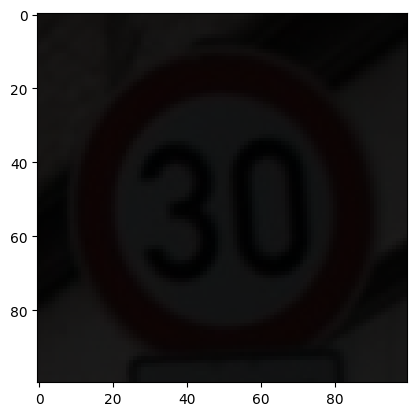

In [ ]:
image = mpimg.imread("data1_YOLO/train/1/3202.jpg")
low_lighting = adjust_brightness(image)
plt.imshow(low_lighting)
plt.show()

#### Prepairing The Snowy Weather Dataset

In [6]:
# coping the data file
shutil.copytree("data1_YOLO", "data_snowy_YOLO")


'data_snowy_YOLO'

In [8]:
def generate_random_flakes(imshape, center_x, center_y, center_radius, flake_size_range):
    flakes = []
    num_flakes = 70
    
    for _ in range(num_flakes):
        angle = np.random.uniform(0, 2 * np.pi)
        radius = np.random.uniform(0, center_radius)
        
        x = center_x + int(radius * np.cos(angle))
        y = center_y + int(radius * np.sin(angle))
        
        size = np.random.randint(flake_size_range[0], flake_size_range[1])
        flakes.append((x, y, size))
    
    return flakes

def add_center_snow(image):
    center_x = image.shape[1] // 2
    center_y = image.shape[0] // 2
    center_radius = 30

    imshape = image.shape
    flake_size_range = (1, 4.5)
    flake_color = (255, 255, 255)
    snowflakes = generate_random_flakes(imshape, center_x, center_y, center_radius, flake_size_range)

    for snowflake in snowflakes:
        x, y, size = snowflake
        cv2.circle(image, (x, y), size, flake_color, -1)

    image = cv2.GaussianBlur(image, (7, 7), 0)

    brightness_coefficient = 1.1
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image_HLS[:, :, 1] = np.clip(image_HLS[:, :, 1] * brightness_coefficient, 0, 255).astype(np.uint8)
    image_RGB = cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)

    return image_RGB




def process_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                if image is not None:
                    adjusted_image = add_center_snow(image)
                    cv2.imwrite(file_path, adjusted_image)


data_folder = "data_snowy_YOLO"
subfolders = ['train', 'val', 'test']
for subfolder in subfolders:
    directory = os.path.join(data_folder, subfolder)
    process_images(directory)




An Example of Snow

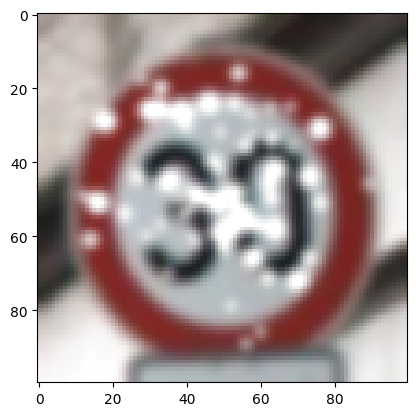

In [ ]:
image = mpimg.imread("data1_YOLO/train/1/3202.jpg")

snow = add_center_snow(image, center_x=image.shape[1] // 2, center_y=image.shape[0] // 2, center_radius=40)
plt.imshow(snow)
plt.show()



#### Prepairing The Rainy Weather Dataset

In [2]:
# coping the data file
shutil.copytree("data1_YOLO", "data_rainy_YOLO")


'data_rainy_YOLO'

In [4]:

def generate_rain_drops(image_shape, slant_angle, drop_length):
    num_drops = 30  # rain intensity
    x_limits = (max(0, slant_angle), image_shape[1] - max(0, slant_angle))  # X coordinate of the starting point of the line
    y_limits = (0, image_shape[0] - drop_length)  # Y coordinate of the starting point of the line
    return [(np.random.randint(*x_limits), np.random.randint(*y_limits)) for _ in range(num_drops)]


def apply_rain_effect(image):
    imshape = image.shape
    slant_angle = np.random.randint(-10, 10)  # random angle between -10 and 10
    rain_drops = generate_rain_drops(imshape, slant_angle, drop_length=6)

    for x, y in rain_drops:
        cv2.line(image, (x, y), (x + slant_angle, y + 6), (200, 200, 200), 2)

    # blurring the image
    blurred_image = cv2.blur(image, (7, 7))

    # change brightness
    brightness_factor = 0.9
    image_HLS = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HLS)
    image_HLS[:, :, 1] = np.clip(image_HLS[:, :, 1] * brightness_factor, 0, 255).astype(np.uint8)

    # Converting the image back to RGB 
    return cv2.cvtColor(image_HLS, cv2.COLOR_HLS2RGB)



def process_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                if image is not None:
                    adjusted_image = add_rain(image)
                    cv2.imwrite(file_path, adjusted_image)


data_folder = "data_rainy_YOLO"
subfolders = ['train', 'val', 'test']
for subfolder in subfolders:
    directory = os.path.join(data_folder, subfolder)
    process_images(directory)

An Example of Rain

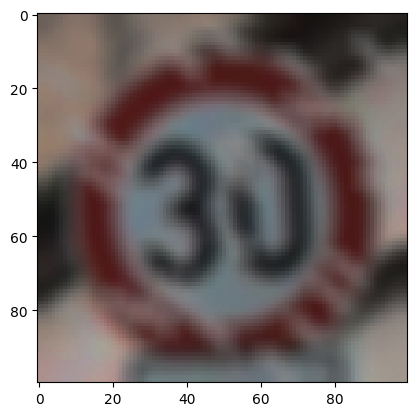

In [ ]:
image = mpimg.imread("data1_YOLO/train/1/3202.jpg")
rain=apply_rain_effect(image)
plt.imshow(rain)
plt.show()


#### Prepairing The Foggy Weather Dataset

In [5]:
# coping the data file
shutil.copytree("data1_YOLO", "data_foggy_YOLO")

'data_foggy_YOLO'

In [6]:
def apply_random_fog_and_blur(image):
    # generating random fog and blur intensities
    fog_intensity = np.random.uniform(0.1, 0.5)
    blur_intensity = np.random.uniform(1, 3)

    # generating a random noise to simulate fog
    noise = np.random.normal(0, 25, image.shape).astype('uint8')

    # adding the noise to the image
    foggy_image = cv2.add(image, noise)

    # blending the foggy image with the original image
    blended_image = cv2.addWeighted(image, 1 - fog_intensity, foggy_image, fog_intensity, 0)

    # applying Gaussian blur
    blurred_image = cv2.GaussianBlur(blended_image, (0, 0), blur_intensity)

    return blurred_image

def process_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                file_path = os.path.join(root, file)
                image = cv2.imread(file_path)
                if image is not None:
                    adjusted_image = apply_random_fog_and_blur(image)
                    cv2.imwrite(file_path, adjusted_image)


data_folder = "data_foggy_YOLO"
subfolders = ['train', 'val', 'test']
for subfolder in subfolders:
    directory = os.path.join(data_folder, subfolder)
    process_images(directory)

An Example of Fog

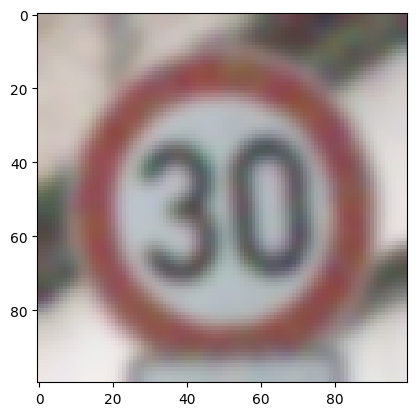

In [ ]:

# Load the image
image = mpimg.imread("data1_YOLO/train/1/3202.jpg")

result = apply_random_fog_and_blur(image)
plt.imshow(result)
plt.show()


#### Prepairing The Extreme Weather Condetions Dataset

In [7]:
# copying the data file
shutil.copytree("data1_YOLO", "data_weather_YOLO")


'data_weather_YOLO'

In [ ]:
def rename_files_in_subfolder(subfolder_path):
    files = glob.glob(os.path.join(subfolder_path, '*.*'))
    file_count = len(files)
    
 
    file_indices = list(range(file_count))
    random.shuffle(file_indices)  # Shuffling the images to randomize their renaming
    
    third_count = file_count // 3
    
    for i, index in enumerate(file_indices):
        if i < third_count:
            category = 'A'
            new_name = category + str(random.randint(0, third_count - 1))
        elif i < third_count * 2:
            category = 'B'
            new_name = category + str(random.randint(third_count, third_count * 2 - 1))
        else:
            category = 'C'
            new_name = category + str(random.randint(third_count * 2, file_count - 1))
        
        file_extension = os.path.splitext(files[index])[1]  
        new_file_name = os.path.join(subfolder_path, new_name + file_extension)
        
        # making sure the filename is not already exist
        while os.path.exists(new_file_name):
            new_name = category + str(random.randint(0, file_count - 1))
            new_file_name = os.path.join(subfolder_path, new_name + file_extension)
        
        os.rename(files[index], new_file_name)
        print(f"Renamed '{files[index]}' to '{new_file_name}'")

def rename_files(folder_path):
    for subfolder in glob.glob(os.path.join(folder_path, '**'), recursive=True):
        if os.path.isdir(subfolder):
            rename_files_in_subfolder(subfolder)


folder_path = 'data_weather_YOLO'
rename_files(folder_path)


In [10]:
data_folder = 'data_weather_YOLO'

# A dictionary mapping starting characters to functions
function_mapping = {
    'A': add_rain,
    'B': add_center_snow,
    'C': apply_random_fog_and_blur,
}

# iterating through each file and its subfolders
for root, _, files in os.walk(data_folder):
    for filename in files:
        image_path = os.path.join(root, filename)
        if os.path.isfile(image_path):
            starting_char = filename[0]  # getting the starting character
            if starting_char in function_mapping:
                # calling the corresponding function based on the starting character
                function = function_mapping[starting_char]
                processed_image = function(cv2.imread(image_path))
                cv2.imwrite(image_path, processed_image)  
            else:
                print("No matching function for:", image_path)


## Training the model

In [2]:

os.environ['WANDB_DISABLED'] = 'true' 

In [8]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
       
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 3060 Laptop GPU


### Normal Weather And Lighting Conditions Dataset

In [ ]:
# Load a model
model = YOLO('yolov8n-cls.pt')  

# Train the model 
results = model.train(data="data1_YOLO", epochs=20)

Model Evaluation

In [6]:
# Measuring the accuracy:

# Load a model

model = YOLO("runs/classify/models/model_normal/weights/last.pt")  

# test the model
metrics = model.val(data="data1_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")


Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data1_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data1_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data1_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:02<00:00, 4804.41it/s]


val: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data1_YOLO\val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 114.73it/s]


                   all      0.966      0.999
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 96.57 %


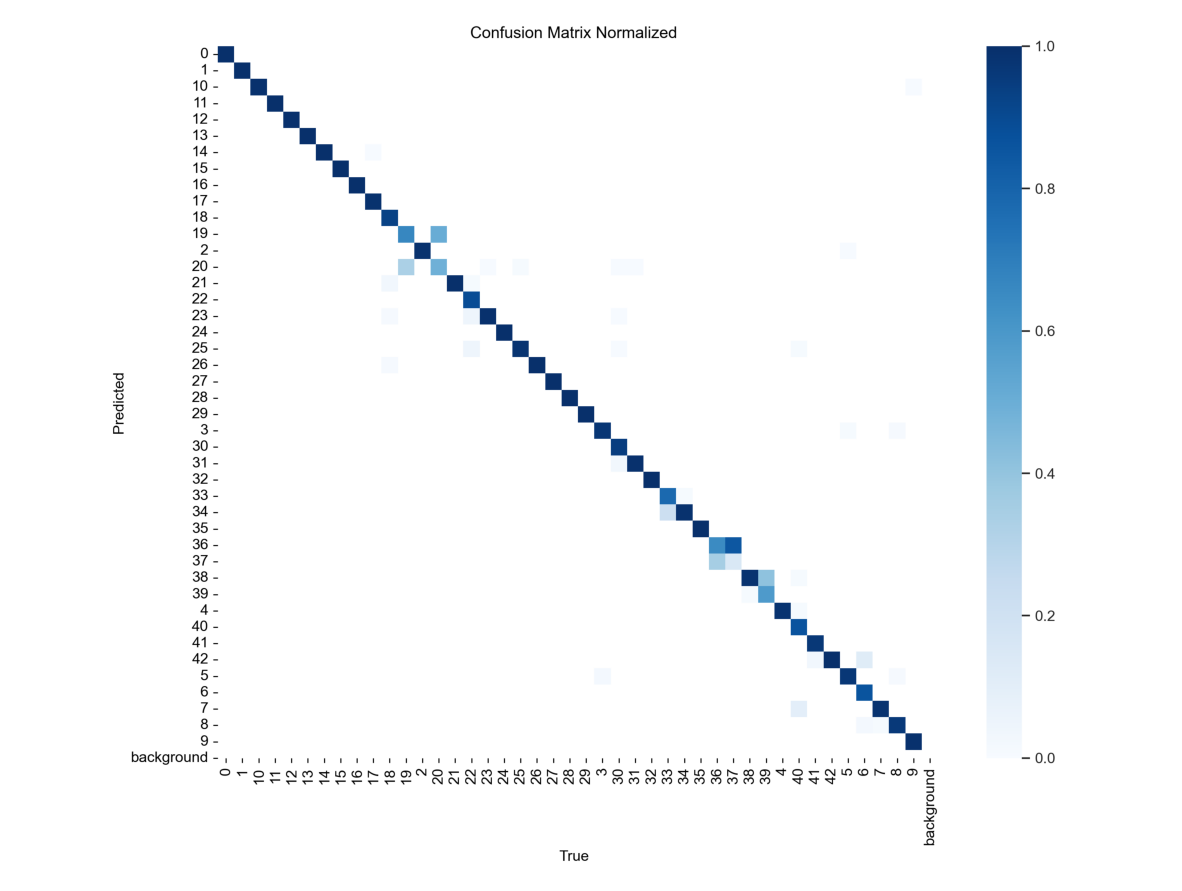

In [7]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/val_normal_weather_and_lighting_before_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Hyperparameter tuning

In [5]:
# Initialize the YOLO model
model = YOLO("runs/classify/model_normal/weights/last.pt")

# Tune hyperparameters 
model.tune(data="data1_YOLO", epochs=20, iterations=5, optimizer="auto", plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs\classify\tune3'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning


Tuner: Starting iteration 1/3 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs\classify\tune3\tune_scatter_plots.png
Saved runs\classify\tune3\tune_fitness.png

Tuner: 1/3 iterations complete  (1771.45s)
Tuner: Results saved to runs\classify\tune3
Tuner: Best fitness=0.98163 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/accuracy_top1': 0.96508, 'metrics/accuracy_top5': 0.99818, 'val/loss': 2.83984, 'fitness': 0.98163}
Tuner: Best fitness model is runs\classify\train9
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs\classify\tune3\best_hyperparameters.yaml'

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight

In [8]:
# Measuring the accuracy:


model = YOLO("runs/classify/models/model_normal_tuned/weights/best.pt")  

# test the model
metrics = model.val(data='data1_YOLO')  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data1_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data1_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data1_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 122.97it/s]


                   all      0.967      0.999
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 96.68 %


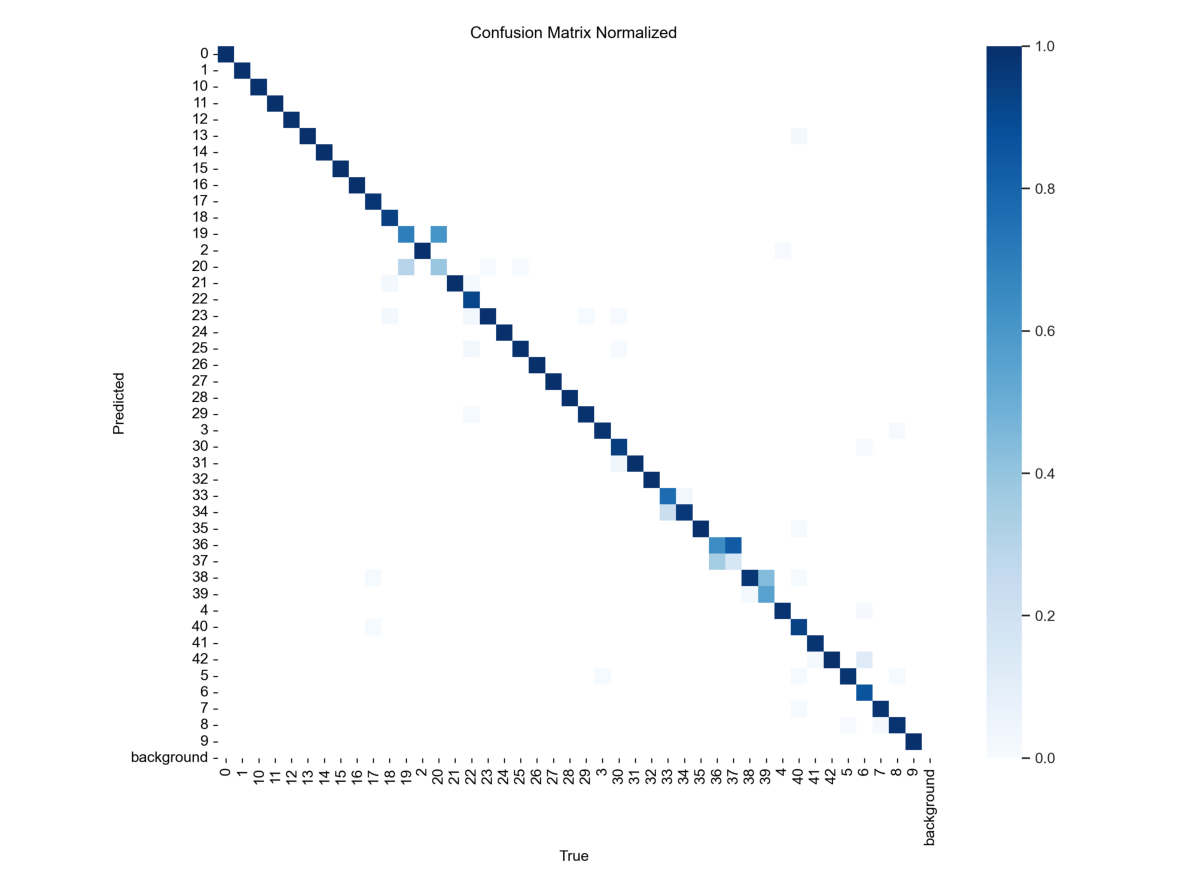

In [9]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/val_normal_wether_and_lighting_afet_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

### Low Lighting Dataset:

In [ ]:
# Load a model
model_2 = YOLO('yolov8n-cls.pt')  

# Train the model 
results = model_2.train(data="data_lighting_YOLO", epochs=20)

In [10]:
# measuring the accuarcy on the test set:

# Load the model

model_2 = YOLO("runs/classify/models/model_lighting/weights/last.pt")  

# test the model
metrics = model_2.val(data="data_lighting_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")


Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:02<00:00, 4638.49it/s]


val: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 117.26it/s]


                   all      0.964      0.998
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 96.36 %


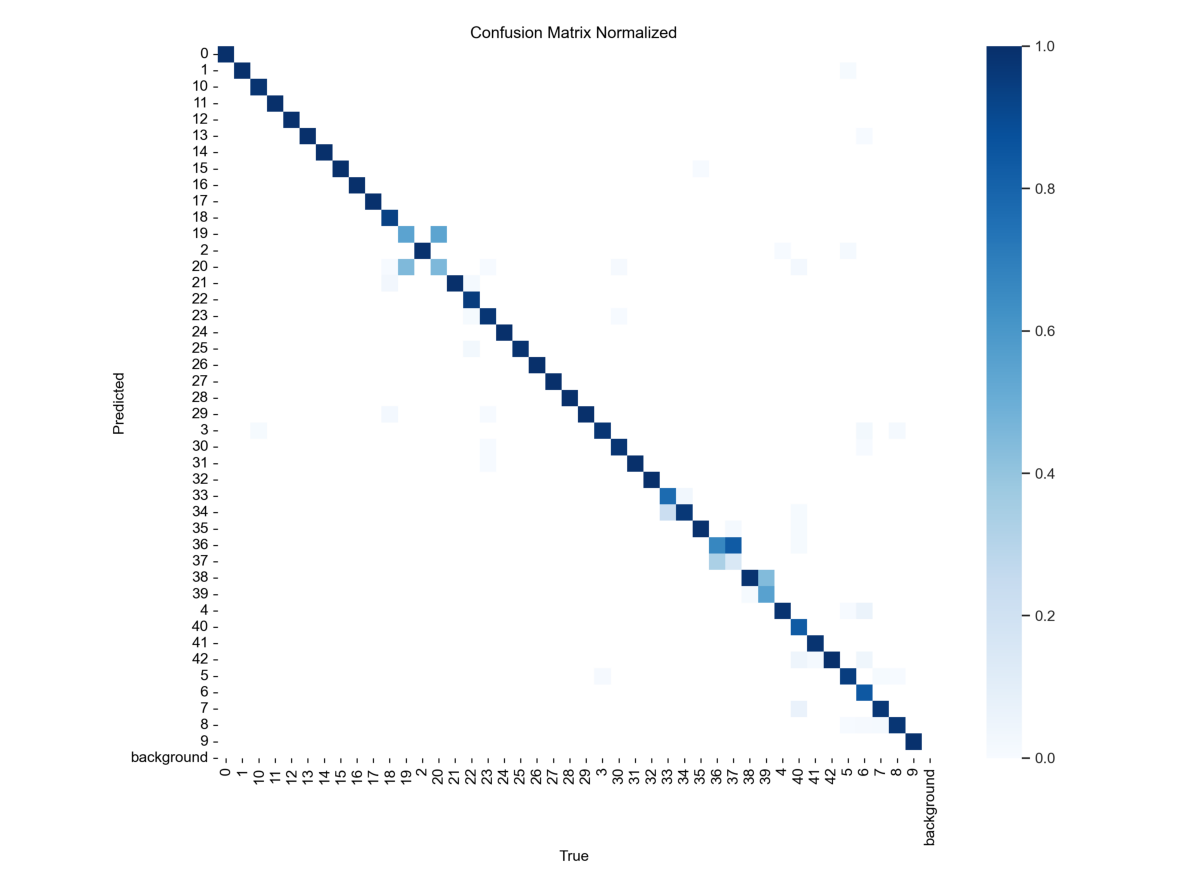

In [11]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/val_low_lighting_before_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Hyperparameter tuning

In [4]:

# Initialize the YOLO model
model = YOLO("runs/classify/models/model_lighting/weights/best.pt")

# Tune hyperparameters
model.tune(data="data_lighting_YOLO", epochs=20, iterations=5, optimizer="auto", plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs\classify\tune'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/5 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs\classify\tune\tune_scatter_plots.png
Saved runs\classify\tune\tune_fitness.png

Tuner: 1/5 iterations complete  (2929.56s)
Tuner: Results saved to runs\classify\tune
Tuner: Best fitness=0.99877 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/accuracy_top1': 0.99779, 'metrics/accuracy_top5': 0.99974, 'val/loss': 2.80429, 'fitness': 0.99877}
Tuner: Best fitness model is runs\classify\train
Tun

In [12]:
# Measuring the accuracy:

# Load a model

model = YOLO("runs/classify/models/model_lighting_tuned/weights/best.pt")  

# testing the model
metrics = model.val(data='data_lighting_YOLO')  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 125.94it/s]


                   all      0.965      0.998
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 96.5 %


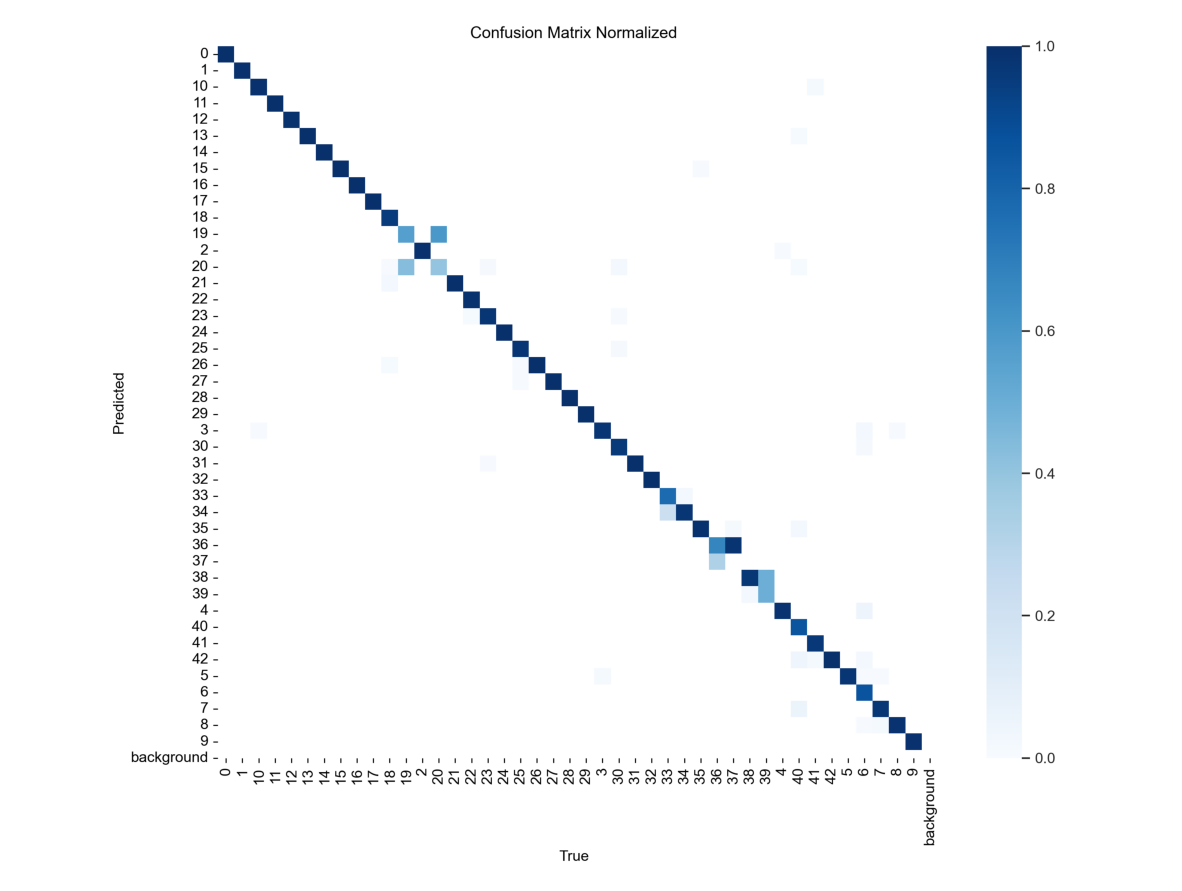

In [13]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/val_low_lighting_after_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

### Extreme Weather Dataset

In [ ]:
# Load a model
model_3 = YOLO('yolov8n-cls.pt')  

# Train the model 
results = model_3.train(data="data_weather_YOLO", epochs=20)

In [37]:
# testing on the test set 

# Load a model
model = YOLO("runs/classify/models/model_weather/weights/last.pt")  

# test the model
metrics = model.val(data="data_weather_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")


Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_weather_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_weather_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_weather_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:02<00:00, 5593.19it/s]


val: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_weather_YOLO\val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 120.92it/s]


                   all      0.906       0.99
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 90.62 %


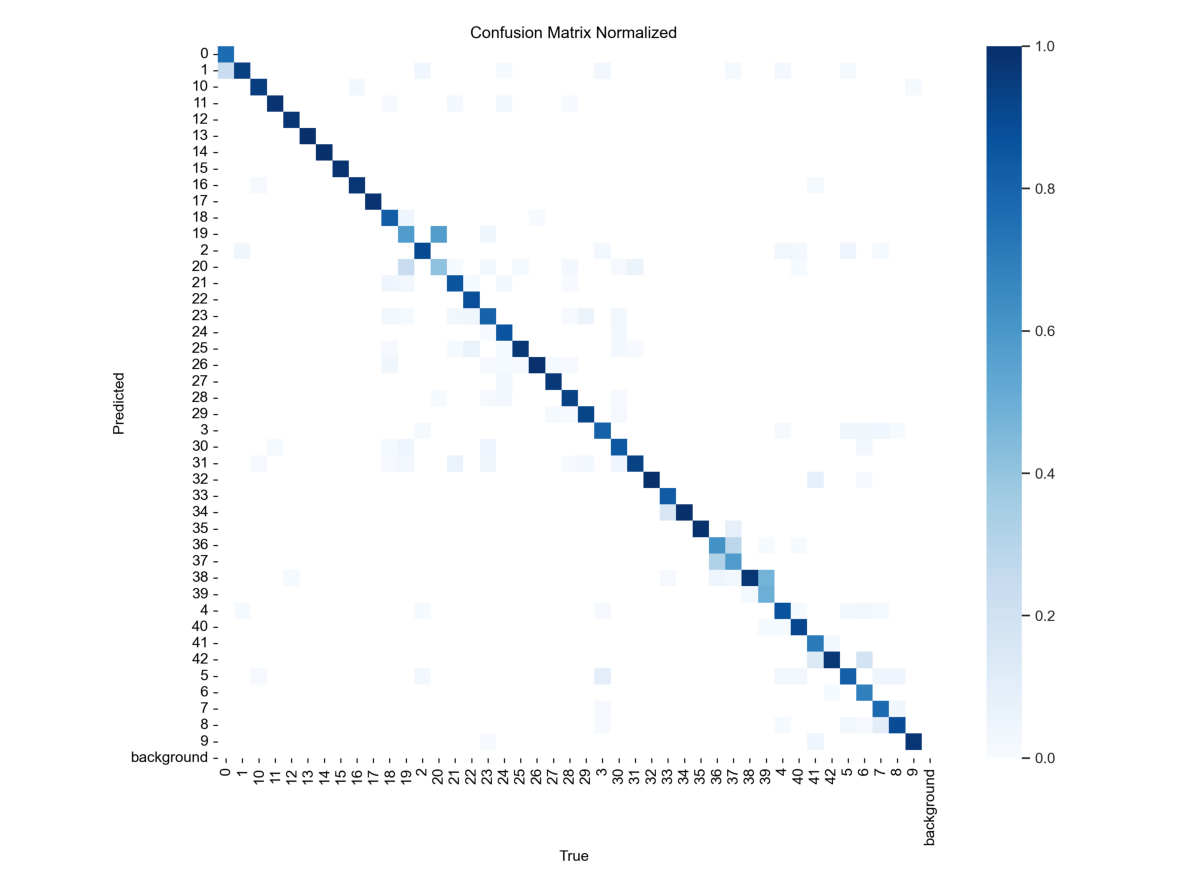

In [38]:
conf_matrix  = Image.open("runs/classify/val_extream_weather_before_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

In [36]:
# Load the YOLO model
model = YOLO("runs/classify/models/model_weather/weights/best.pt")

# Tune hyperparameters 
model.tune(data="data_weather_YOLO", epochs=20, iterations=5, optimizer="auto", plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs\classify\tune'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/5 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs\classify\tune\tune_scatter_plots.png
Saved runs\classify\tune\tune_fitness.png

Tuner: 1/5 iterations complete  (3117.00s)
Tuner: Results saved to runs\classify\tune
Tuner: Best fitness=0.99201 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/accuracy_top1': 0.9847, 'metrics/accuracy_top5': 0.99932, 'val/loss': 2.82618, 'fitness': 0.99201}
Tuner: Best fitness model is runs\classify\train
Tune

In [39]:
# Load a model

model = YOLO("runs/classify/models/model_weather_tuned/weights/best.pt")  

# test the model
metrics = model.val(data="data_weather_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")


Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_weather_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_weather_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_weather_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:08<00:00, 97.39it/s] 


                   all       0.91       0.99
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 90.98 %


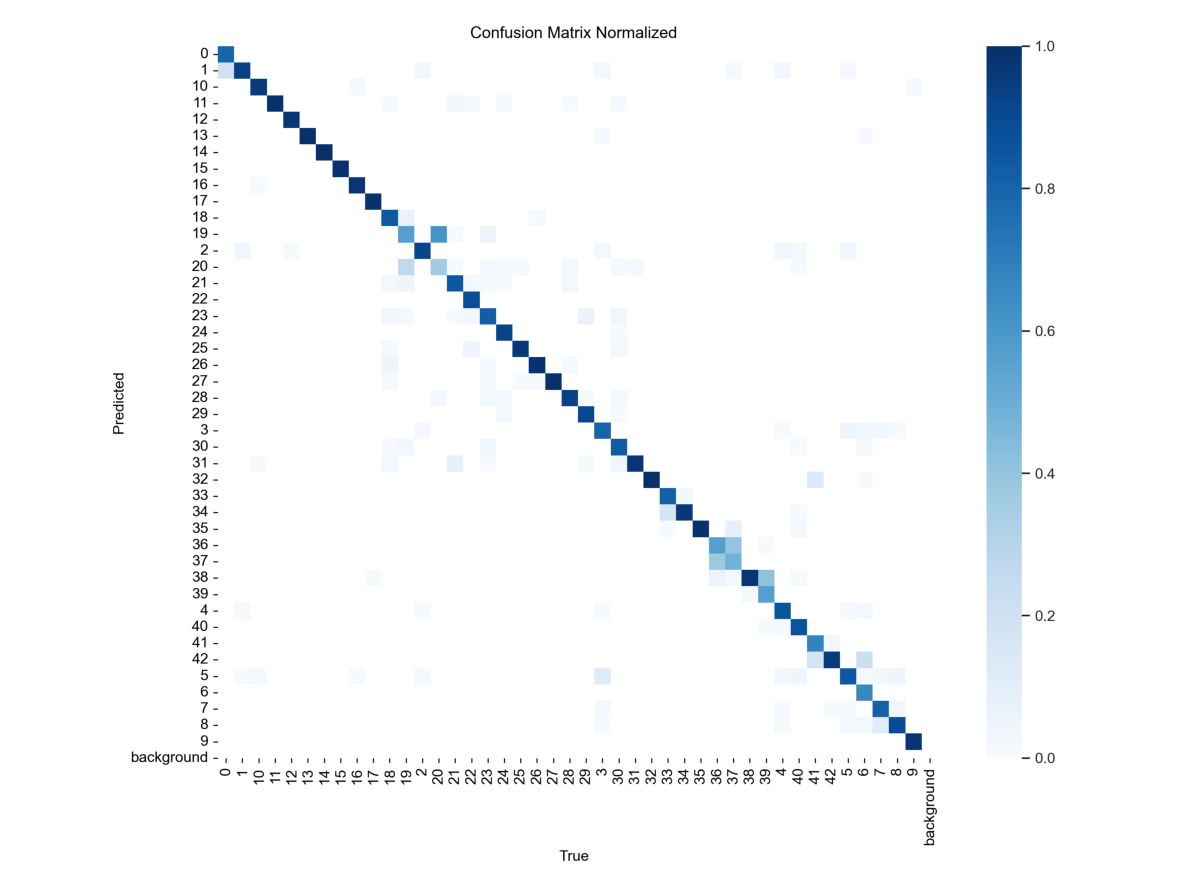

In [40]:
conf_matrix  = Image.open("runs/classify/val_extream_weather_after_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

### Snowy Weather Dataset

In [9]:
# Load the model
model = YOLO('yolov8n-cls.pt')  

# Train the model 
results = model.train(data="data_snowy_YOLO", epochs=20)

New https://pypi.org/project/ultralytics/8.2.85 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=data_snowy_YOLO, epochs=20, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed 


train: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\train... 68585 images, 0 corrupt: 100%|██████████| 68585/68585 [00:11<00:00, 5789.94it/s]


train: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\train.cache


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... 11763 images, 0 corrupt: 100%|██████████| 11763/11763 [00:02<00:00, 5454.11it/s]


val: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\classify\train
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 66.29it/s]

                   all      0.605      0.934



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 65.05it/s]

                   all      0.799       0.98



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 63.43it/s]

                   all      0.853      0.986



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 62.36it/s]

                   all      0.889      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.94it/s]

                   all      0.919      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.08it/s]

                   all      0.936      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 61.93it/s]

                   all      0.949      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.59it/s]

                   all      0.955      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.52it/s]

                   all      0.959      0.999



      Epoch    GPU_mem       loss  Instances       Size


      10/20     0.505G     0.2362          9        224: 100%|██████████| 4287/4287 [02:20<00:00, 30.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 61.70it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.508G     0.2186          9        224: 100%|██████████| 4287/4287 [02:23<00:00, 29.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 59.80it/s]

                   all      0.968      0.999



      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.508G     0.2008          9        224: 100%|██████████| 4287/4287 [02:19<00:00, 30.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 55.52it/s]

                   all       0.97      0.999



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.508G     0.1797          9        224: 100%|██████████| 4287/4287 [02:26<00:00, 29.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.82it/s]

                   all      0.973      0.999



      Epoch    GPU_mem       loss  Instances       Size


      14/20     0.505G     0.1707          9        224: 100%|██████████| 4287/4287 [02:24<00:00, 29.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.12it/s]

                   all      0.975      0.999



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.508G      0.148          9        224: 100%|██████████| 4287/4287 [02:35<00:00, 27.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 53.86it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.508G     0.1339          9        224: 100%|██████████| 4287/4287 [02:30<00:00, 28.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.26it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20     0.508G     0.1204          9        224: 100%|██████████| 4287/4287 [02:24<00:00, 29.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:07<00:00, 52.14it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20     0.508G      0.106          9        224: 100%|██████████| 4287/4287 [02:23<00:00, 29.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.80it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20     0.508G    0.09536          9        224: 100%|██████████| 4287/4287 [02:23<00:00, 29.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 53.51it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20     0.508G    0.08725          9        224: 100%|██████████| 4287/4287 [02:31<00:00, 28.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 58.47it/s]

                   all      0.981          1



20 epochs completed in 0.839 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.1MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.1MB

Validating runs\classify\train\weights\best.pt...
Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... found 11763 images in 43 classes  
test: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\test... found 12630 images in 43 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.59it/s]


                   all      0.981          1
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train
Results saved to runs\classify\train


lr/pg0,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/accuracy_top1,▁▅▆▆▇▇▇█████████████
metrics/accuracy_top5,▁▆▇▇████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg0,0.0006


In [15]:
# testing on the test set

snow_model = YOLO("runs/classify/snowy/model_snowy/weights/last.pt")  

# test the model
metrics = snow_model.val(data="data_snowy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 127.48it/s]


                   all      0.864      0.986
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 86.41 %


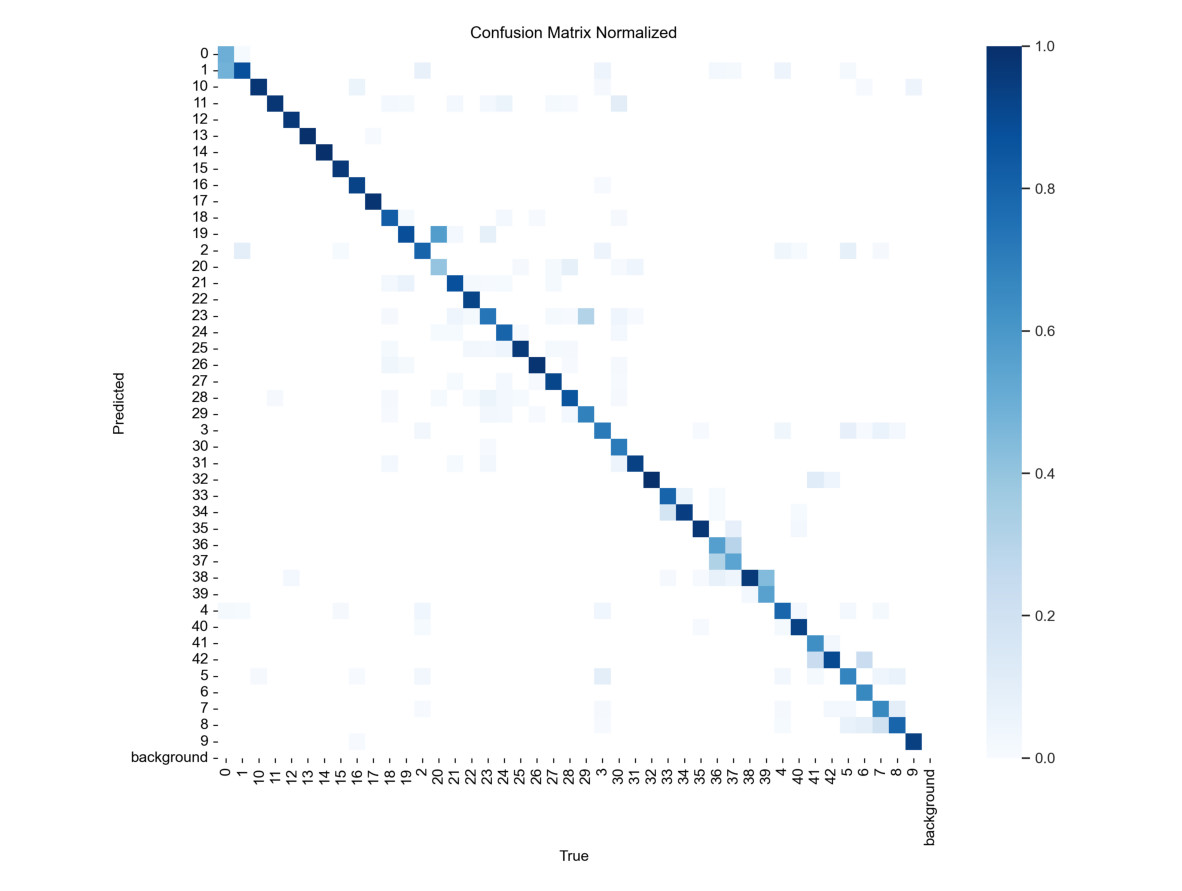

In [16]:
conf_matrix  = Image.open("runs/classify/val_snowy_before_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Hyperparameter tuning

In [20]:
# Initialize the YOLO model
model = YOLO("runs/classify/train/weights/last.pt")

# Tune hyperparameters for 20 epochs
model.tune(data="data_snowy_YOLO", epochs=20, iterations=4, optimizer="auto", plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs\classify\tune'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/4 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs\classify\tune\tune_scatter_plots.png
Saved runs\classify\tune\tune_fitness.png

Tuner: 1/4 iterations complete  (2935.96s)
Tuner: Results saved to runs\classify\tune
Tuner: Best fitness=0.99422 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/accuracy_top1': 0.98886, 'metrics/accuracy_top5': 0.99957, 'val/loss': 2.82098, 'fitness': 0.99422}
Tuner: Best fitness model is runs\classify\train2
Tu

Tuning results

In [17]:
# testing on the test set

snow_model = YOLO("runs/classify/snowy/tune_snowy/weights/best.pt")  

# test the model
metrics = snow_model.val(data="data_snowy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 132.78it/s]


                   all      0.879      0.987
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 87.94 %


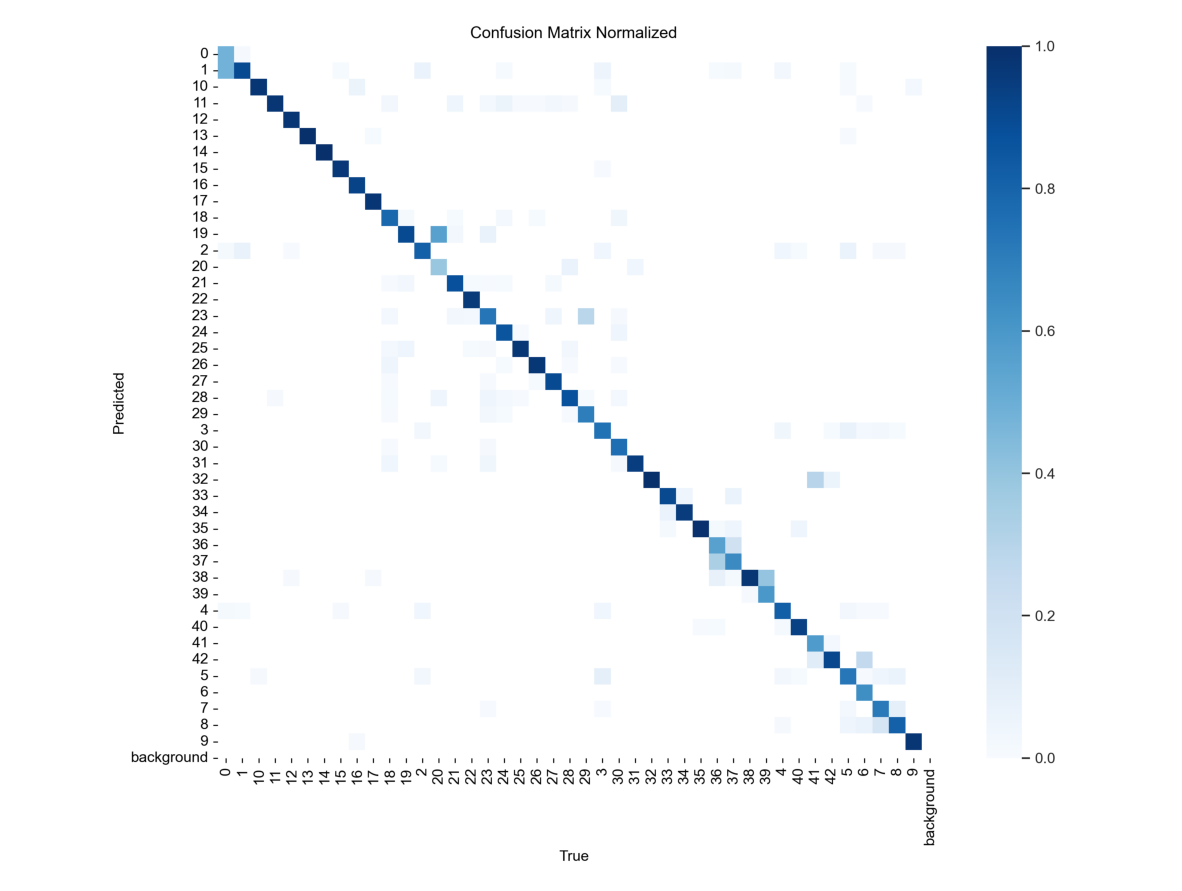

In [18]:
conf_matrix  = Image.open("runs/classify/val_snowy_after_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

### Rainy Weather Dataset

In [7]:
# Load a model
model = YOLO('yolov8n-cls.pt')  # load a pretrained model 

# Train the model 
results = model.train(data="data_rainy_YOLO", epochs=20)

New https://pypi.org/project/ultralytics/8.2.86 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=data_rainy_YOLO, epochs=20, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed 


train: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\train... 68585 images, 0 corrupt: 100%|██████████| 68585/68585 [00:11<00:00, 5870.78it/s]


train: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\train.cache


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... 11763 images, 0 corrupt: 100%|██████████| 11763/11763 [00:02<00:00, 5718.33it/s]


val: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\classify\train
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 62.57it/s]

                   all      0.752       0.97



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.72it/s]

                   all      0.895      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.14it/s]


                   all      0.933      0.996

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 60.10it/s]

                   all      0.948      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 59.59it/s]

                   all      0.965      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.23it/s]

                   all      0.971      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 58.91it/s]


                   all      0.976      0.999

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 58.10it/s]

                   all      0.981      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:07<00:00, 50.52it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20      0.51G     0.1614          9        224: 100%|██████████| 4287/4287 [02:33<00:00, 27.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 58.55it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.512G     0.1474          9        224: 100%|██████████| 4287/4287 [02:30<00:00, 28.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.72it/s]


                   all      0.986          1

      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.512G     0.1389          9        224: 100%|██████████| 4287/4287 [02:32<00:00, 28.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.03it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.512G     0.1214          9        224: 100%|██████████| 4287/4287 [02:33<00:00, 27.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.70it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20      0.51G     0.1165          9        224: 100%|██████████| 4287/4287 [02:32<00:00, 28.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 56.82it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.512G     0.1031          9        224: 100%|██████████| 4287/4287 [02:32<00:00, 28.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.52it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.512G    0.09049          9        224: 100%|██████████| 4287/4287 [02:32<00:00, 28.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 58.10it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20     0.512G    0.08244          9        224: 100%|██████████| 4287/4287 [02:32<00:00, 28.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 58.07it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      0.51G    0.07411          9        224: 100%|██████████| 4287/4287 [02:33<00:00, 27.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 56.49it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20     0.512G    0.06486          9        224: 100%|██████████| 4287/4287 [02:35<00:00, 27.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.74it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20     0.512G     0.0625          9        224: 100%|██████████| 4287/4287 [02:34<00:00, 27.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 56.30it/s]

                   all      0.991          1



20 epochs completed in 0.895 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.1MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.1MB

Validating runs\classify\train\weights\best.pt...
Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... found 11763 images in 43 classes  
test: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\test... found 12630 images in 43 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 56.06it/s]


                   all      0.991          1
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train
Results saved to runs\classify\train


lr/pg0,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/accuracy_top1,▁▅▆▇▇▇██████████████
metrics/accuracy_top5,▁▆▇█████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg0,0.0006


In [19]:
# testing on the test set

snow_model = YOLO("runs/classify/rainy/model_rainy/weights/last.pt")  

# Test the model
metrics = snow_model.val(data="data_rainy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 126.11it/s]


                   all      0.941      0.996
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 94.12 %


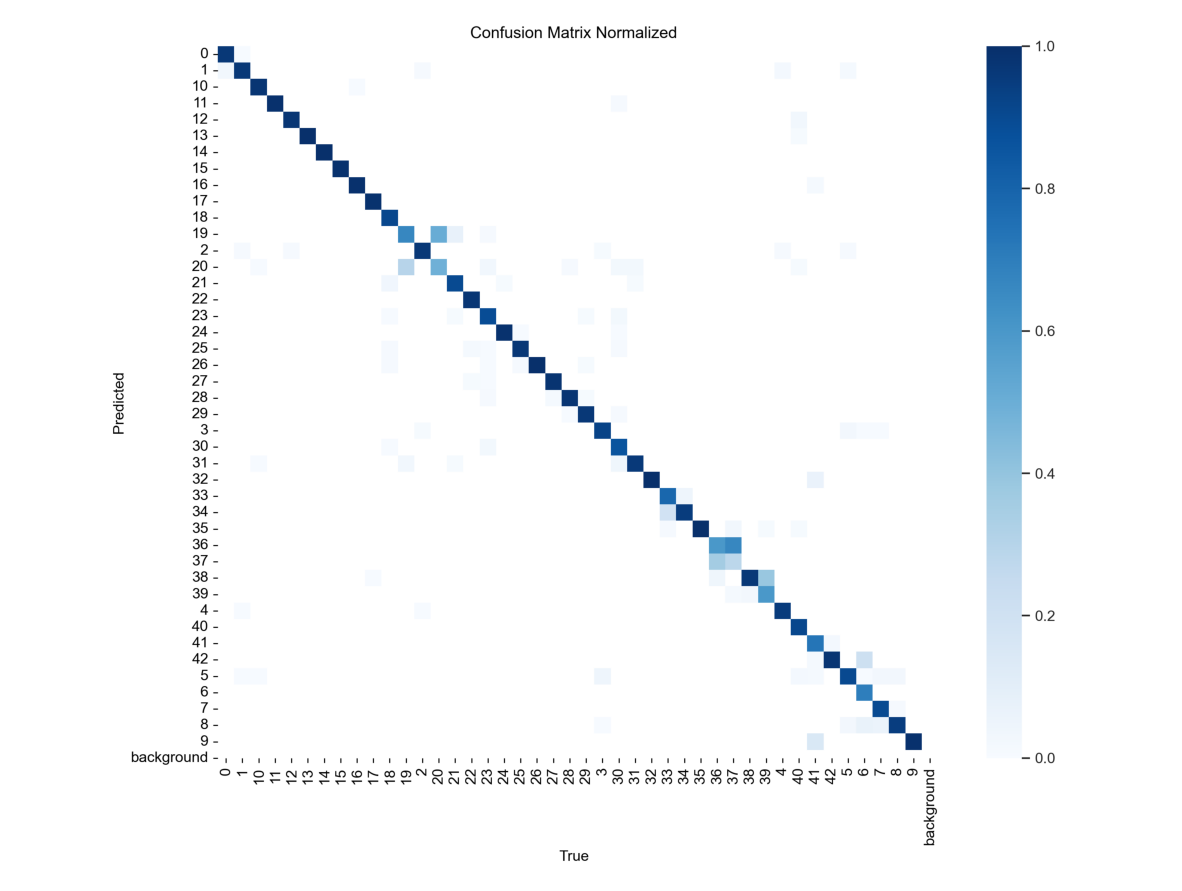

In [20]:
# Confusion Matrix :

conf_matrix  = Image.open("runs/classify/val_rainy_before_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Hyperparameter tuning

In [10]:
# Initialize the YOLO model
model = YOLO("runs/classify/rainy/model_rainy/weights/best.pt")

# Tune hyperparameters for 20 epochs
model.tune(data="data_rainy_YOLO", epochs=20, iterations=4, optimizer="auto", plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs\classify\tune'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/4 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}


Saved runs\classify\tune\tune_scatter_plots.png
Saved runs\classify\tune\tune_fitness.png

Tuner: 1/4 iterations complete  (2958.87s)
Tuner: Results saved to runs\classify\tune
Tuner: Best fitness=0.99668 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/accuracy_top1': 0.99354, 'metrics/accuracy_top5': 0.99983, 'val/loss': 2.81082, 'fitness': 0.99668}
Tuner: Best fitness model is runs\classify\train
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs\classify\tune\best_hyperparameters.yaml'

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
box: 7.5
cls: 0.5
dfl: 1.5
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
bgr: 0.0
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0

Tuner: Starting iteration 2/4 with hyperparameters: {'lr0': 0.00991, 'lrf': 0.01, 'momentum': 0.94241, 'weight_decay': 0.00051, 'warmup_epochs': 3.0, 'warmup_momentum':

Tuning results

In [21]:
# testing on the test set

snow_model = YOLO("runs/classify/rainy/tune_rainy/weights/best.pt")  

# test the model
metrics = snow_model.val(data="data_rainy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 132.31it/s]


                   all       0.95      0.995
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 95.04 %


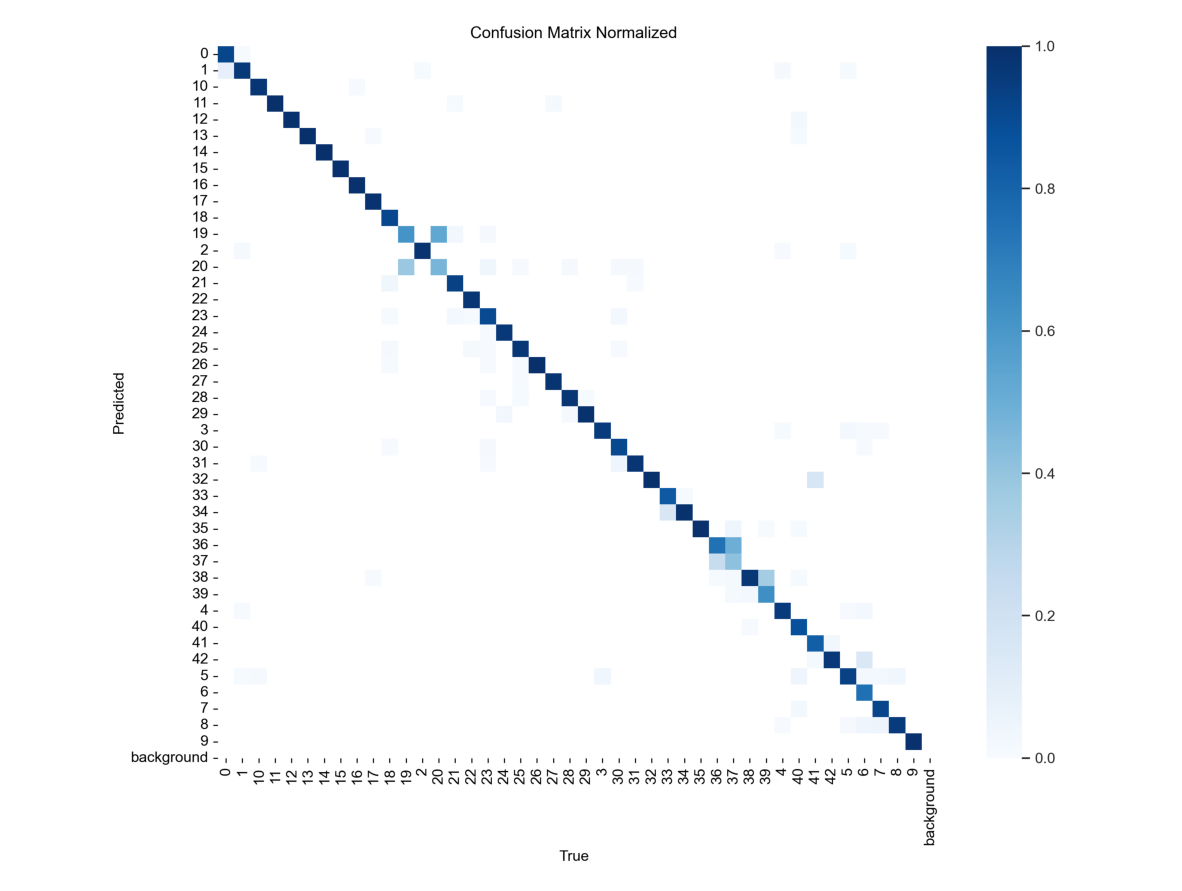

In [22]:
conf_matrix  = Image.open("runs/classify/val_rainy_after_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

### Foggy Weather Dataset

In [17]:
# Load a model
model = YOLO('yolov8n-cls.pt')  # load a pretrained model 

# Train the model 
results = model.train(data="data_foggy_YOLO", epochs=20)

New https://pypi.org/project/ultralytics/8.2.87 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=data_foggy_YOLO, epochs=20, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

train: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\train... 68585 images, 0 corrupt: 100%|██████████| 68585/68585 [00:00<?, ?it/s]
val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... 11763 images, 0 corrupt: 100%|██████████| 11763/11763 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\classify\train
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 61.00it/s]

                   all      0.854      0.981



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 61.80it/s]

                   all      0.936      0.992



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 56.12it/s]

                   all      0.949      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:07<00:00, 48.04it/s]

                   all      0.966      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 59.86it/s]

                   all      0.974      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 61.42it/s]

                   all      0.976      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 63.38it/s]

                   all      0.981      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 61.77it/s]

                   all      0.981      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 59.43it/s]

                   all      0.985      0.998



      Epoch    GPU_mem       loss  Instances       Size


      10/20     0.514G     0.1647          9        224: 100%|██████████| 4287/4287 [02:39<00:00, 26.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 57.65it/s]

                   all      0.984      0.999



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.514G     0.1489          9        224: 100%|██████████| 4287/4287 [02:40<00:00, 26.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 56.86it/s]

                   all      0.986      0.998



      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.514G     0.1412          9        224: 100%|██████████| 4287/4287 [02:34<00:00, 27.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 61.84it/s]

                   all      0.987      0.998



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.516G     0.1254          9        224: 100%|██████████| 4287/4287 [02:26<00:00, 29.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 63.04it/s]

                   all      0.987      0.998



      Epoch    GPU_mem       loss  Instances       Size


      14/20     0.514G     0.1214          9        224: 100%|██████████| 4287/4287 [02:25<00:00, 29.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:06<00:00, 61.23it/s]

                   all      0.987      0.998



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.514G     0.1097          9        224: 100%|██████████| 4287/4287 [02:25<00:00, 29.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 63.69it/s]


                   all      0.987      0.999

      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.514G      0.104          9        224: 100%|██████████| 4287/4287 [02:24<00:00, 29.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 64.99it/s]

                   all      0.987      0.999



      Epoch    GPU_mem       loss  Instances       Size


      17/20     0.516G    0.09299          9        224: 100%|██████████| 4287/4287 [02:25<00:00, 29.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 64.31it/s]

                   all      0.987      0.999



      Epoch    GPU_mem       loss  Instances       Size


      18/20     0.514G    0.08422          9        224: 100%|██████████| 4287/4287 [02:25<00:00, 29.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 63.98it/s]

                   all      0.987      0.999



      Epoch    GPU_mem       loss  Instances       Size


      19/20     0.514G    0.07485          9        224: 100%|██████████| 4287/4287 [02:24<00:00, 29.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 65.15it/s]


                   all      0.988      0.999

      Epoch    GPU_mem       loss  Instances       Size


      20/20     0.514G    0.06947          9        224: 100%|██████████| 4287/4287 [02:24<00:00, 29.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 63.83it/s]

                   all      0.988      0.999



20 epochs completed in 0.893 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.1MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.1MB

Validating runs\classify\train\weights\best.pt...
Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... found 11763 images in 43 classes  
test: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\test... found 12630 images in 43 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 368/368 [00:05<00:00, 65.19it/s]


                   all      0.988      0.999
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train
Results saved to runs\classify\train


lr/pg0,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/accuracy_top1,▁▅▆▇▇▇██████████████
metrics/accuracy_top5,▁▅▆▇█▇█▇████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr/pg0,0.0006


In [23]:
# testing on the test set

snow_model = YOLO("runs/classify/foggy/model_fog/weights/last.pt")  

# test the model
metrics = snow_model.val(data="data_foggy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:02<00:00, 5799.20it/s]


val: New cache created: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val.cache


               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 126.95it/s]


                   all      0.943      0.993
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 94.32 %


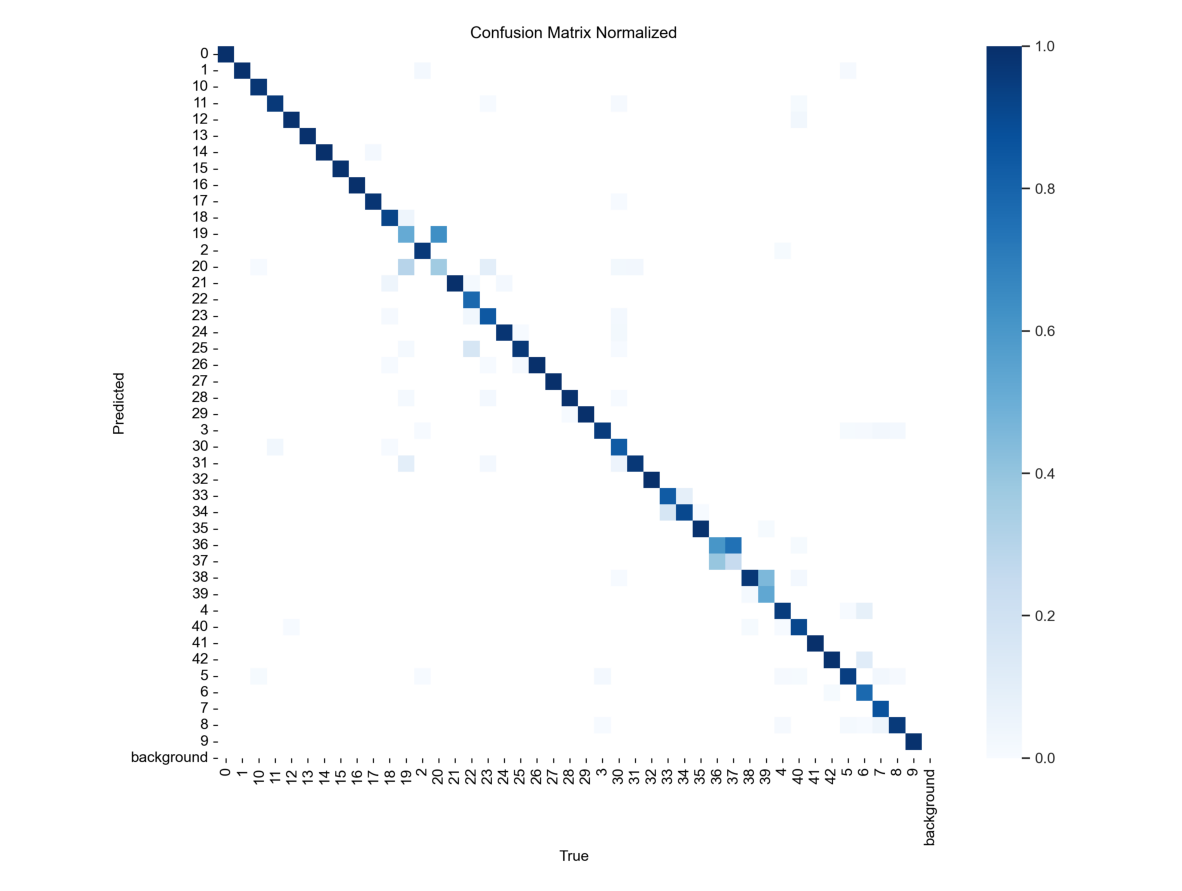

In [24]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/val_foggy_before_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Hyperparameter tuning

In [7]:
# Initialize the YOLO model
model = YOLO("runs/classify/foggy/model_fog/weights/best.pt")

# Tune hyperparameters for 20 epochs
model.tune(data="data_foggy_YOLO", epochs=20, iterations=4, optimizer="auto", plots=False, save=False, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs\classify\tune'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/4 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs\classify\tune\tune_scatter_plots.png
Saved runs\classify\tune\tune_fitness.png

Tuner: 1/4 iterations complete  (3122.11s)
Tuner: Results saved to runs\classify\tune
Tuner: Best fitness=0.99477 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/accuracy_top1': 0.99039, 'metrics/accuracy_top5': 0.99915, 'val/loss': 2.81472, 'fitness': 0.99477}
Tuner: Best fitness model is runs\classify\train
Tun

In [25]:
# testing on the test set

snow_model = YOLO("runs/classify/foggy/tune_foggy/weights/best.pt")  

# test the model
metrics = snow_model.val(data="data_foggy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 136.49it/s]


                   all      0.942      0.993
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val2
The accueracy of the model is : 94.22 %


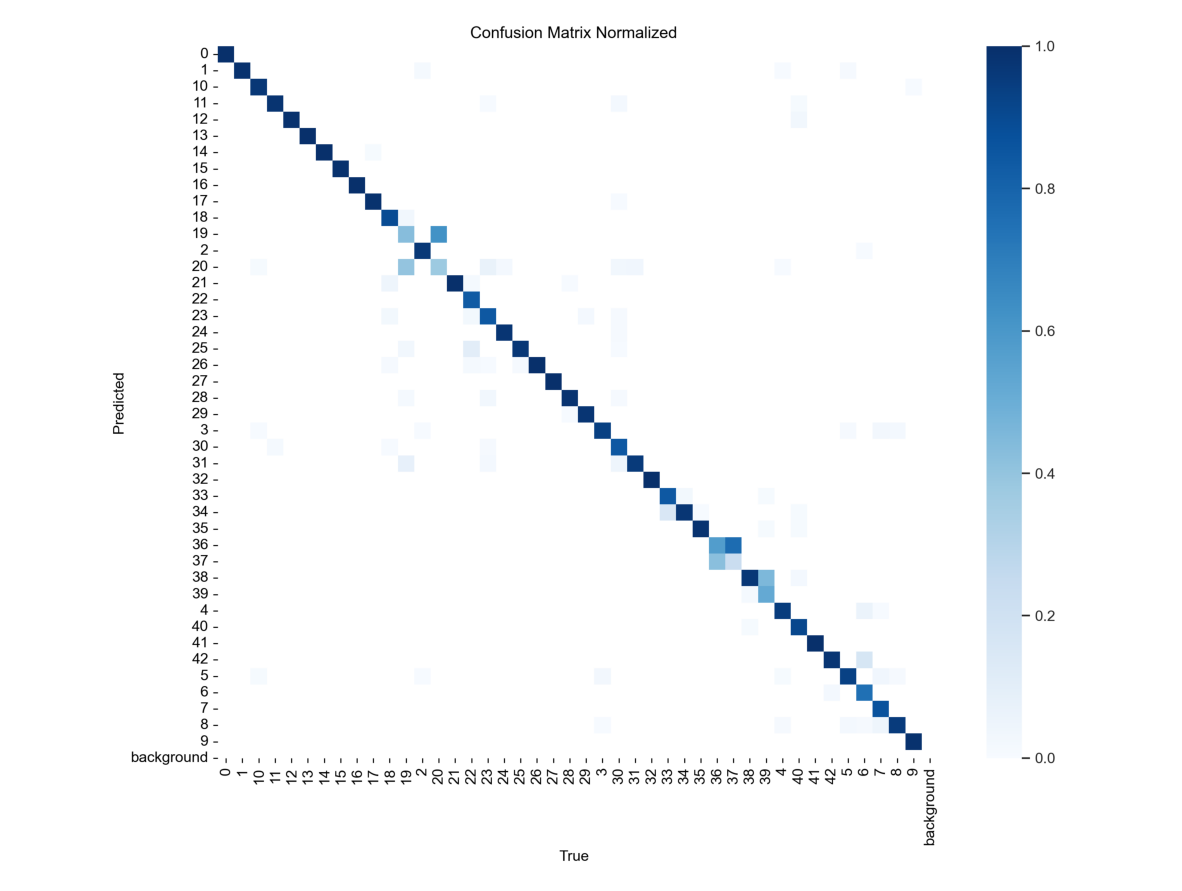

In [26]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/val_foggy_after_tuning/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

### Evaluting the models on differant test sets

Now we will evaluate the (snow, Rain, fog, low-lighting) test sets on the model trained on the normal weather and lighting dataset to see how these conditions affected the accuracy of the model 

Snowy Dataset

In [27]:
# Load the model
Normal_weather_and_lighting_model = YOLO("runs/classify/models/model_normal_tuned/weights/best.pt")  

# testing the model on the snowy weather test set
metrics = Normal_weather_and_lighting_model.val(data="data_snowy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 133.47it/s]


                   all      0.409      0.674
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 40.92 %


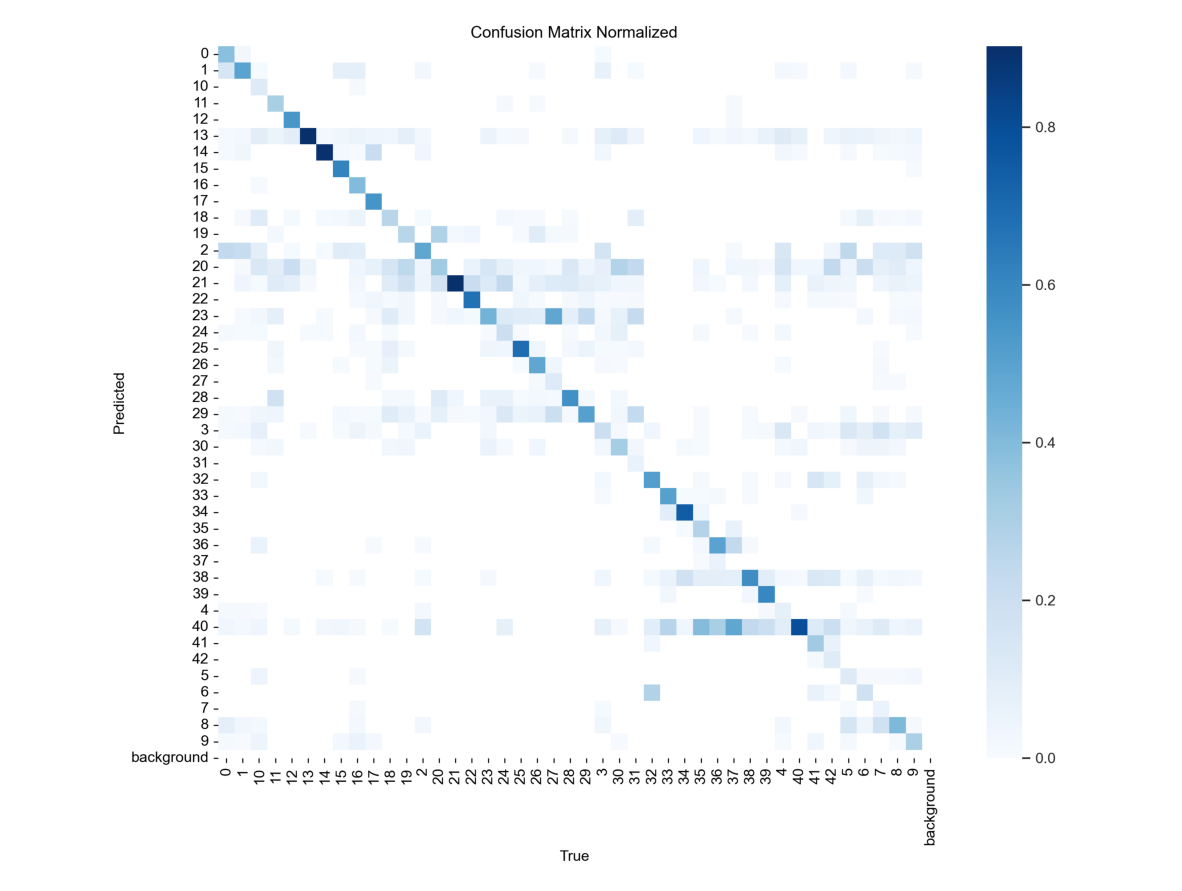

In [28]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/other_data/snowy_on_normal/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Rainy Dataset

In [29]:
# Load the model
Normal_weather_and_lighting_model = YOLO("runs/classify/models/model_normal_tuned/weights/best.pt")  

# testing the model on the rainy weather test set
metrics = Normal_weather_and_lighting_model.val(data="data_rainy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:06<00:00, 128.93it/s]


                   all      0.608      0.765
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 60.79 %


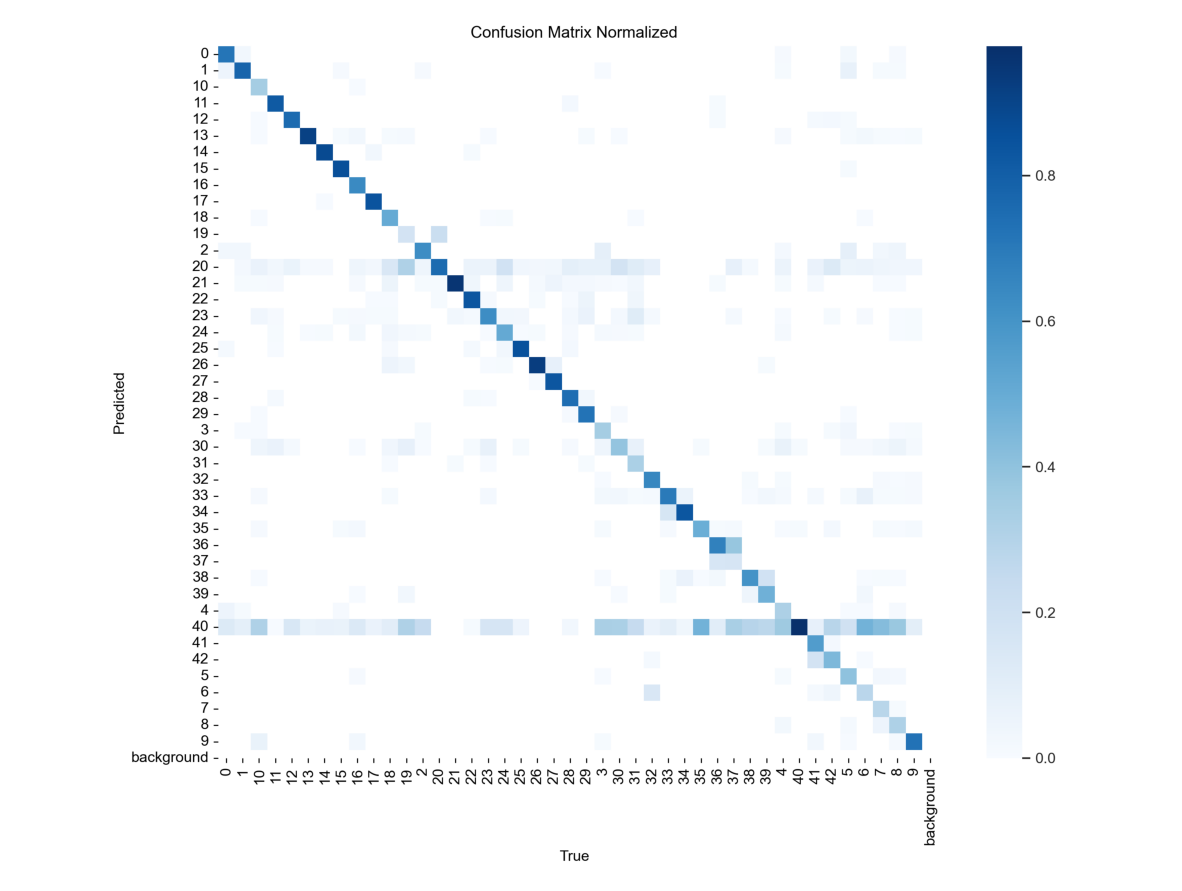

In [30]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/other_data/rainy_on_normal/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Foggy Dataset

In [31]:
# Load the model
Normal_weather_and_lighting_model = YOLO("runs/classify/models/model_normal_tuned/weights/best.pt")  

# testing the model on the foggy weather test set
metrics = Normal_weather_and_lighting_model.val(data="data_foggy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 134.90it/s]


                   all      0.907      0.968
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 90.67 %


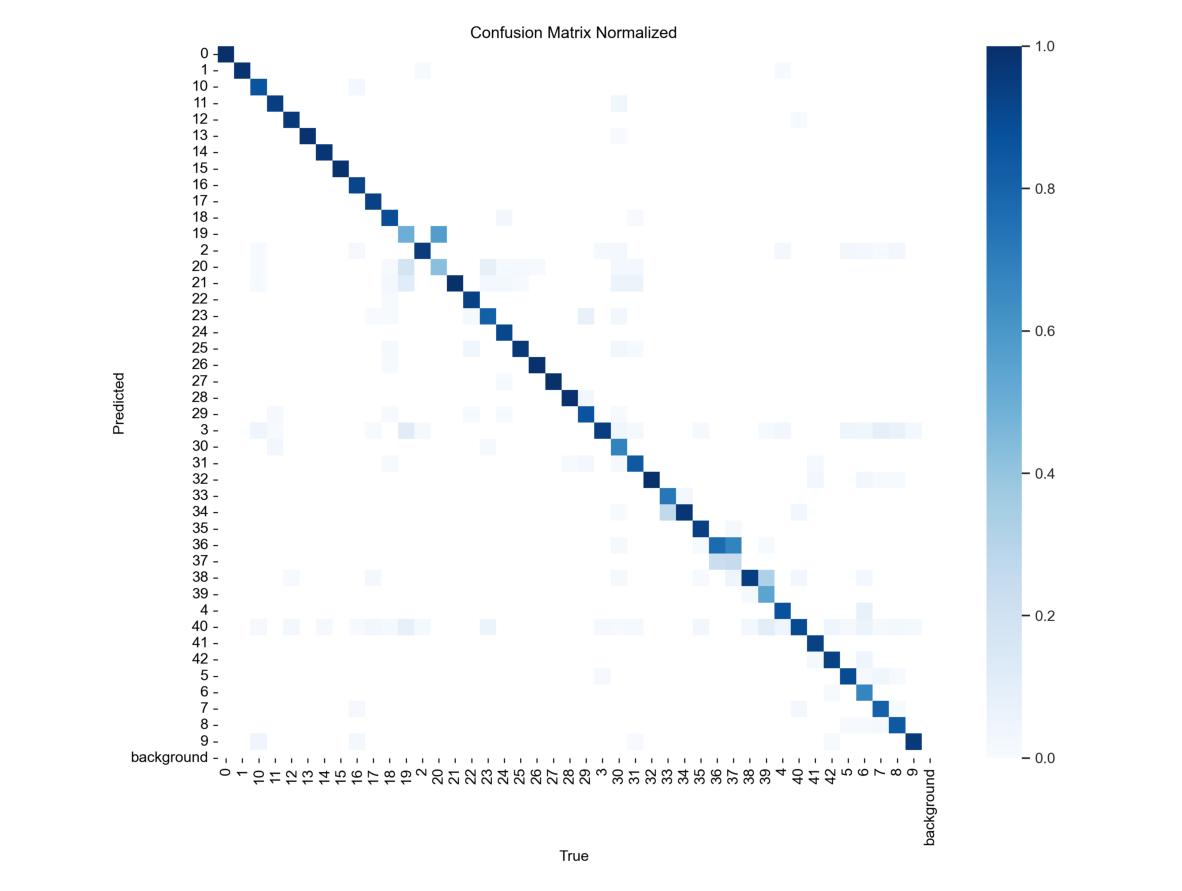

In [32]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/other_data/foggy_on_normal/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Low-lighting Dataset

In [33]:
# Load the model
Normal_weather_and_lighting_model = YOLO("runs/classify/models/model_normal_tuned/weights/best.pt")  

# testing the model on the low-lighting weather test set
metrics = Normal_weather_and_lighting_model.val(data="data_lighting_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_lighting_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 136.23it/s]


                   all      0.896      0.962
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 89.58 %


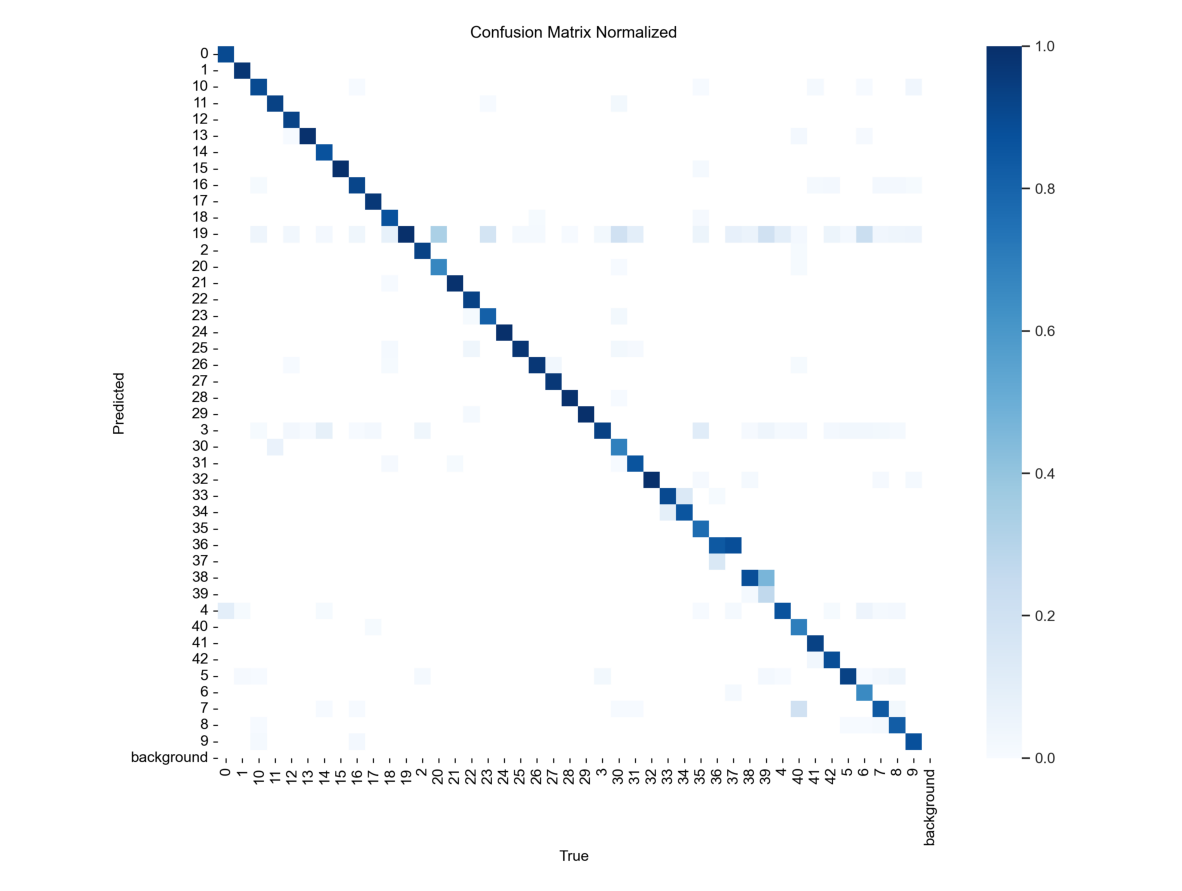

In [34]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/other_data/low_lighting_on_normal/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Now we will test the model trained on extream weather conditions on (snow, rain and fog) dataset

Snow

In [41]:
# Load the model
extreme_weather_model = YOLO("runs/classify/models/model_weather_tuned/weights/best.pt")  

# testing the model on the low-lighting weather test set
metrics = extreme_weather_model.val(data="data_snowy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_snowy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 142.29it/s]


                   all      0.864      0.986
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 86.39 %


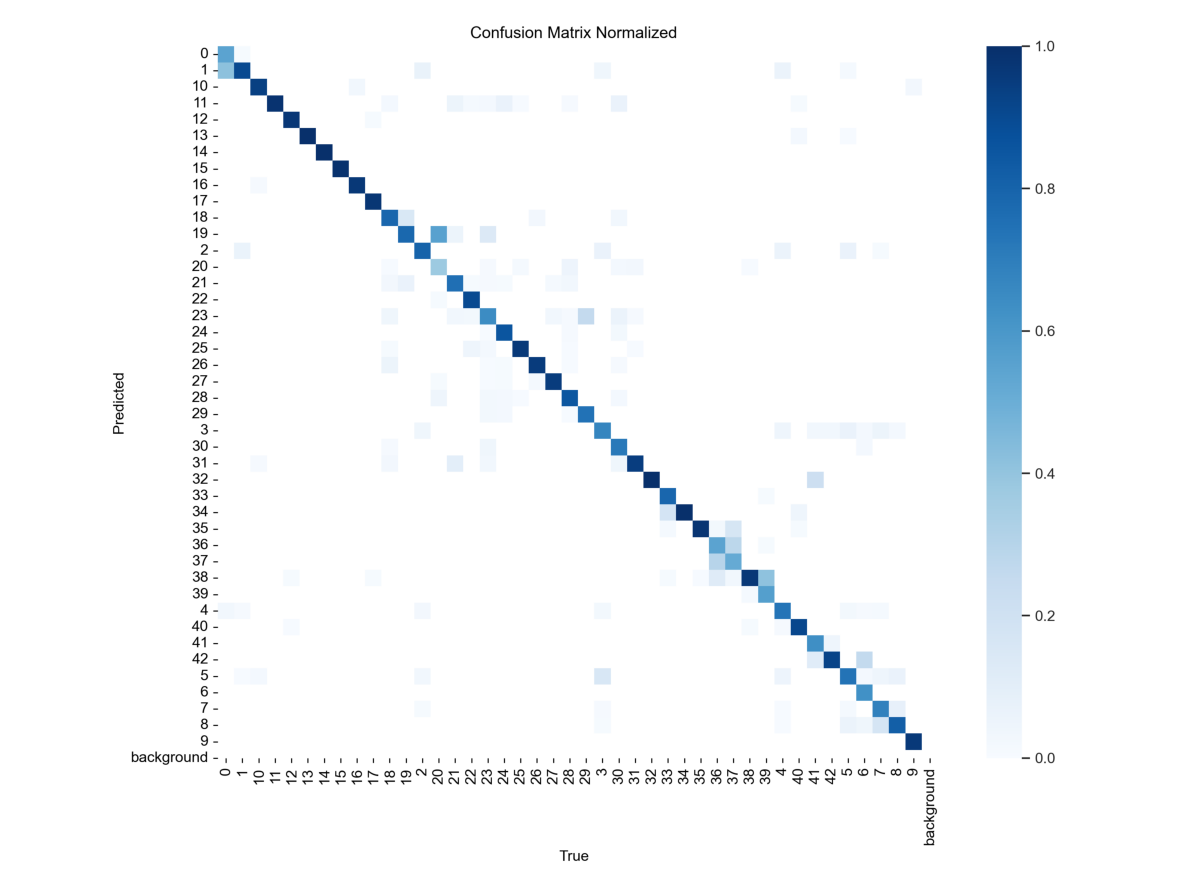

In [42]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/other_data/snowy_on_extreme/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

Rain

In [43]:
# Load the model
extreme_weather_model = YOLO("runs/classify/models/model_weather_tuned/weights/best.pt")  

# testing the model on the low-lighting weather test set
metrics = extreme_weather_model.val(data="data_rainy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_rainy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 135.88it/s]


                   all       0.93      0.994
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 92.97 %


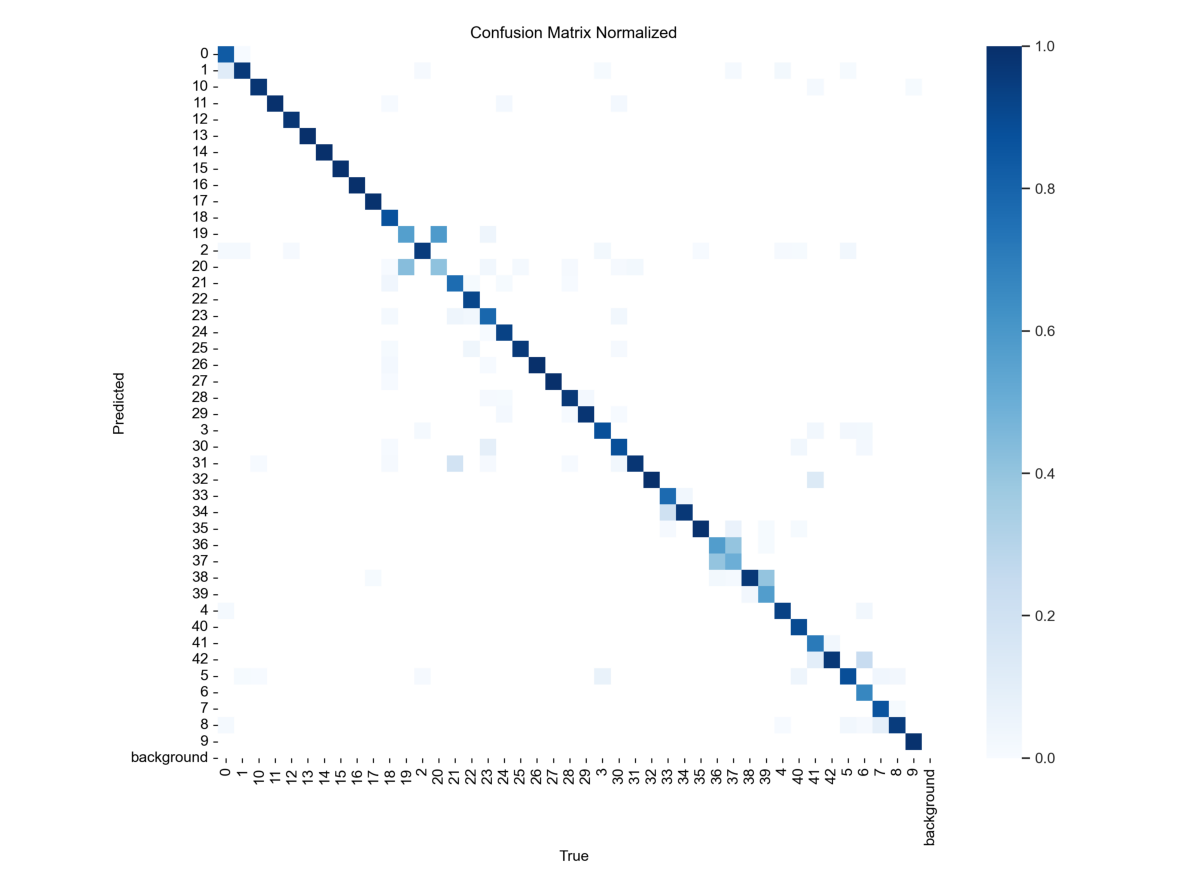

In [44]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/other_data/rainy_on_extreme/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()

fog

In [45]:
# Load the model
extreme_weather_model = YOLO("runs/classify/models/model_weather_tuned/weights/best.pt")  

# testing the model on the low-lighting weather test set
metrics = extreme_weather_model.val(data="data_foggy_YOLO")  
print(f"The accueracy of the model is : {round(metrics.top1*100,2)} %")

Ultralytics YOLOv8.2.75  Python-3.8.2 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,489,963 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\train... found 68585 images in 43 classes  
val: C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... found 12630 images in 43 classes  
test: None...


val: Scanning C:\Users\96278\OneDrive\Desktop\Navigating_Safety_Optimizing_Traffic_Sign_Detection_Models\data_foggy_YOLO\val... 12630 images, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 790/790 [00:05<00:00, 137.87it/s]


                   all      0.936      0.993
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val
The accueracy of the model is : 93.58 %


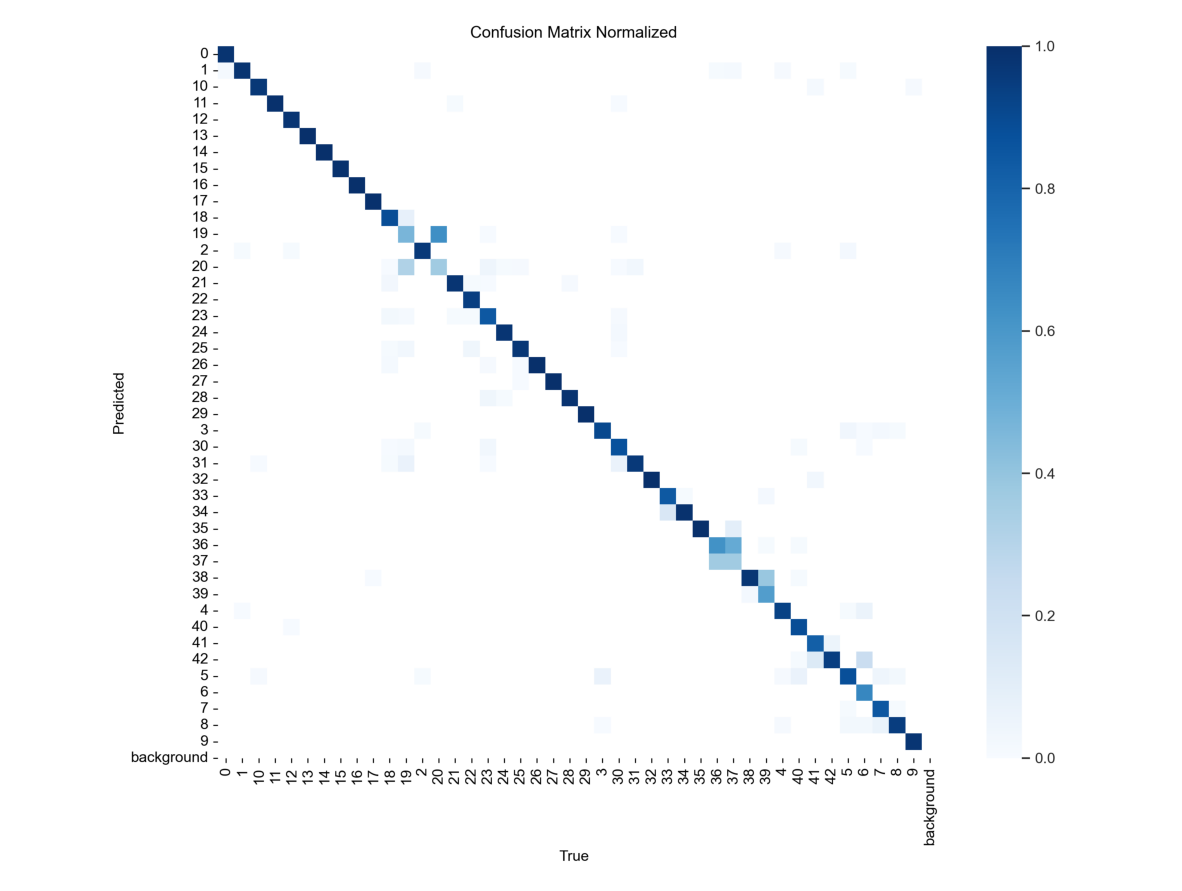

In [46]:
# Confusion Matrix : 

conf_matrix  = Image.open("runs/classify/other_data/foggy_on_extreme/confusion_matrix_normalized.png")


fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(conf_matrix )
plt.axis('off')  
plt.show()